In [2]:
from functools import cmp_to_key
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
import time
import logging

# 0 参数设置

In [282]:
# 升采样参数
PRE_BLUR_SCALE = 2
PRE_BLUR_KSIZE = (0, 0)
# 高斯模糊/掩模参数
PRE_BLUR = 0.5
# 第0层的初始尺度，即第0层高斯模糊所使用的参数
SIFT_SIGMA = 1.6
# 高斯金字塔每组内的层数，S=3
NUM_DIFF_OCTAVES = 3
# 设置参数S，每组图像的层数，实际上这里的INTERVALS+3才是实际的S
NUM_INTVLS = 3
# 边界的像素宽度，检测过程中将忽略边界线中的极值点，即只检测边界线以内是否存在极值点
IMAGE_BORDER_WIDTH = 5
# 对比度阈值 |D(x)|，针对归一化后的图像，用来去除不稳定特征，|D(x)|<0.03此处使用RobHess此处的阈值使用的是0.04/S
CONTRAST_THRESHOLD=0.04
# 主曲率比值的阈值，用来去除边缘特征
RATIO_THRESHOLD=10
# 设置最大迭代次数
NUM_ATTMEPT_UNTIL_CONVERFENCE = 5
# 特征点方向赋值过程中，搜索邻域的半径为：3 * 1.5 * σ，分配方向时高斯权重参数因子，高斯加权（1.5σ）的半径
SCALE_FCTR = 1.5
# 计算特征描述子过程中，特征点周围的d*d个区域中，每个区域的宽度为m*σ个像素
RADIUS_FCTR = 3
# 特征点方向赋值过程中，梯度方向直方图中柱子(bin)的个数，0度~360度分36个柱，每10度一个柱
ORI_HIST_BINS = 36
# 特征点方向赋值过程中，梯度幅值达到最大值的80%则分裂为两个特征点，相当于主峰值80%能量的峰值
ORI_PEAK_RATIO = 0.8
# 计算特征描述子过程中，将特征点附近划分为d*d个区域，每个区域生成一个直方图，论文中设置为4
SIFT_DESCR_WIDTH=4
# 计算特征描述子过程中，每个方向直方图的bin个数，8个方向的梯度直方图
SIFT_DESCR_HIST_BINS=8
# 特征点方向赋值过程中，搜索邻域的半径为：3 * 1.5 * σ，分配方向时计算区域大小，根据3sigma外可忽略，圆半径3σ（3*1.5σ）
SIFT_DESCR_SCL_FCTR=3
# 算特征描述子过程中，特征描述子向量中元素的阈值(最大值，并且是针对归一化后的特征描述子)，超过此阈值的元素被强行赋值为此阈值，归一化处理中，对特征矢量中值大于0.2进行截断（大于0.2只取0.2）
SIFT_DESCR_MAG_THR=0.2

# 1 构建高斯差分尺度空间（DOG）
## 1.1 构建高斯金字塔
1. 升采样：为了尽可能多的保留原始图像的信息，一般首先要对原始图像进行扩大两倍的采样及就是升采样，从而生成Octave-1的图像，原因是因为在相机拍摄的过程中时，图像已经被进行了一次降采样。Lowe在论文中给出的建议是，第1层的尺度建议定为1.6，原图的尺度建议定为0.5，因为取景器（相机），一般会做这样一个处理以维持图片质量。这样就带来了一个问题：因为原图是由0.5的平滑器处理过的，相当于一部分信息已经丢失了。这个时候需要引入刚才到的升采样操作，将原图放大为原来的2倍。由这张放大的图片进行卷积生成第一层第一张图片，才能保证最大程度上利用原图信息。同时，因为第一层的尺度是1.6，但是刚才解释过，原图并不是真正的原图，此时进行卷积的图片的尺度应该是2*0.5=1。那么，此时应用在升采样后的图片上的卷积尺度就应该是$\sigma_{diff} = \sqrt{\sigma_{init}^2 - \sigma_{pre}^2}$用此尺度对升采样后的图片进行卷积，获得第一组第一层。这里升采样我直接使用了opev自带的resize函数，使用双三次插值法。

In [283]:
def Upsampling(img):
    """对图像进行升采样，校准从取景器得到的图像，输入升采样后的图像
    :param img: input image
    :return: base image
    """
    img = img.astype(np.float32)
    img = cv.resize(img, PRE_BLUR_KSIZE, fx=PRE_BLUR_SCALE, fy=PRE_BLUR_SCALE, interpolation=cv.INTER_LINEAR)
    sigma_diff = np.sqrt(max((SIFT_SIGMA ** 2) - ((2 * PRE_BLUR) ** 2), 0.01))
    upsampling_img = cv.GaussianBlur(img, PRE_BLUR_KSIZE, sigmaX=sigma_diff, sigmaY=sigma_diff)
    return upsampling_img

In [284]:
raw_image = cv.imread('xiaogong.jpg', 0)
base_image = Upsampling(raw_image)
print(f"base_image.shape: {base_image.shape},raw_image.shape: {raw_image.shape}")

base_image.shape: (544, 960),raw_image.shape: (272, 480)


2. 获取octaves的数量：构建DOG的第一步就是构建高斯金字塔。具体地讲他是一个金字塔组。它由O组S层图像金字塔构成。每一层内的图像尺寸是一样的，都包含了S+3(下文中会详细说明为啥要在这里+3)个图像，同一组中的所有图像具有相同的宽度和高度，但是模糊量逐渐增加，是后一幅图片是由上一幅图片经过高斯卷积而来。而下一组图象又是由上一组图像经过降采样得到。
3. 定量化的分析：在原始的论文中遵循的规则是$O = \log_2{min(w,h)}-3$,其中，(w,h)分别表示图像的宽和高。对于尺度空间中第o组的第s层图像，其尺度为$\sigma_{s} = \sigma_{init}2^{s/S}$，其中，$\sigma_{init}$是初始的高斯模糊尺度，S是每组图像的层数,一般被设置为6-9层。因此这里我将`numIntervals`设置为3，即每组图像的层数为3+3=6层。最后可以讲组内组间尺度归为公式$2^{o-1}(\sigma,k \sigma,\dots,k^{s+2}\sigma)$，其中$k = 2^{1/s}$，同1中分析的那样，每一层之间的尺度差为$\sigma_{diff} = \sqrt{(\sigma_{init}k^{s+1})^2 - (\sigma_{init}k^s)^2}$。

In [285]:
def Get_Octaves_Num(base_img):
    """获取octaves的数量
    :param base_img: input image
    :return: octaves number
    """
    return int(np.round(np.log2(min(base_img.shape[:2]))) - NUM_DIFF_OCTAVES)

In [286]:
num_octaves = Get_Octaves_Num(base_image)
print(f"num_octaves: {num_octaves}")

num_octaves: 6


In [287]:
def GenerateGaussianKernels():
    """
    生成每一层的高斯核列表。
    """
    S = NUM_INTVLS + 3 # 一组6层图像
    k = 2 ** (1. / NUM_INTVLS)
    gaussian_kernels = np.zeros(S)
    gaussian_kernels[0] = SIFT_SIGMA
    for image_index in range(1, S):
        sigma_previous = (k ** (image_index - 1)) * SIFT_SIGMA
        sigma_total = k * sigma_previous
        gaussian_kernels[image_index] = np.sqrt(sigma_total ** 2 - sigma_previous ** 2)
    return gaussian_kernels

In [288]:
guassian_kernels = GenerateGaussianKernels()
print(f"guassian_kernels: {guassian_kernels}")

guassian_kernels: [1.6        1.2262735  1.54500779 1.94658784 2.452547   3.09001559]


In [289]:
def GenerateGaussianImages(img, num_octaves, gaussian_kernels):
    """生成高斯金字塔
    :param img: input base_image
    :param num_octaves: octaves number
    :param gaussian_kernels: gaussian kernels
    """
    gaussian_imgs = []
    for i in range(num_octaves):
        gaussian_img_per_octave = []
        gaussian_img_per_octave.append(img)
        for kernel in gaussian_kernels[1:]:
            img = cv.GaussianBlur(img, (0, 0), sigmaX=kernel, sigmaY=kernel)
            gaussian_img_per_octave.append(img)
        gaussian_imgs.append(gaussian_img_per_octave)
        # 该组的第三层图像作为下一组的基础图像
        octave_base_img = gaussian_img_per_octave[-3]
        # 降采样
        img = cv.resize(octave_base_img, (int(octave_base_img.shape[1] / 2), int(octave_base_img.shape[0] / 2)), interpolation=cv.INTER_NEAREST)
    return np.array(gaussian_imgs, dtype=object)

In [290]:
gaussian_imgs = GenerateGaussianImages(base_image, num_octaves, guassian_kernels)

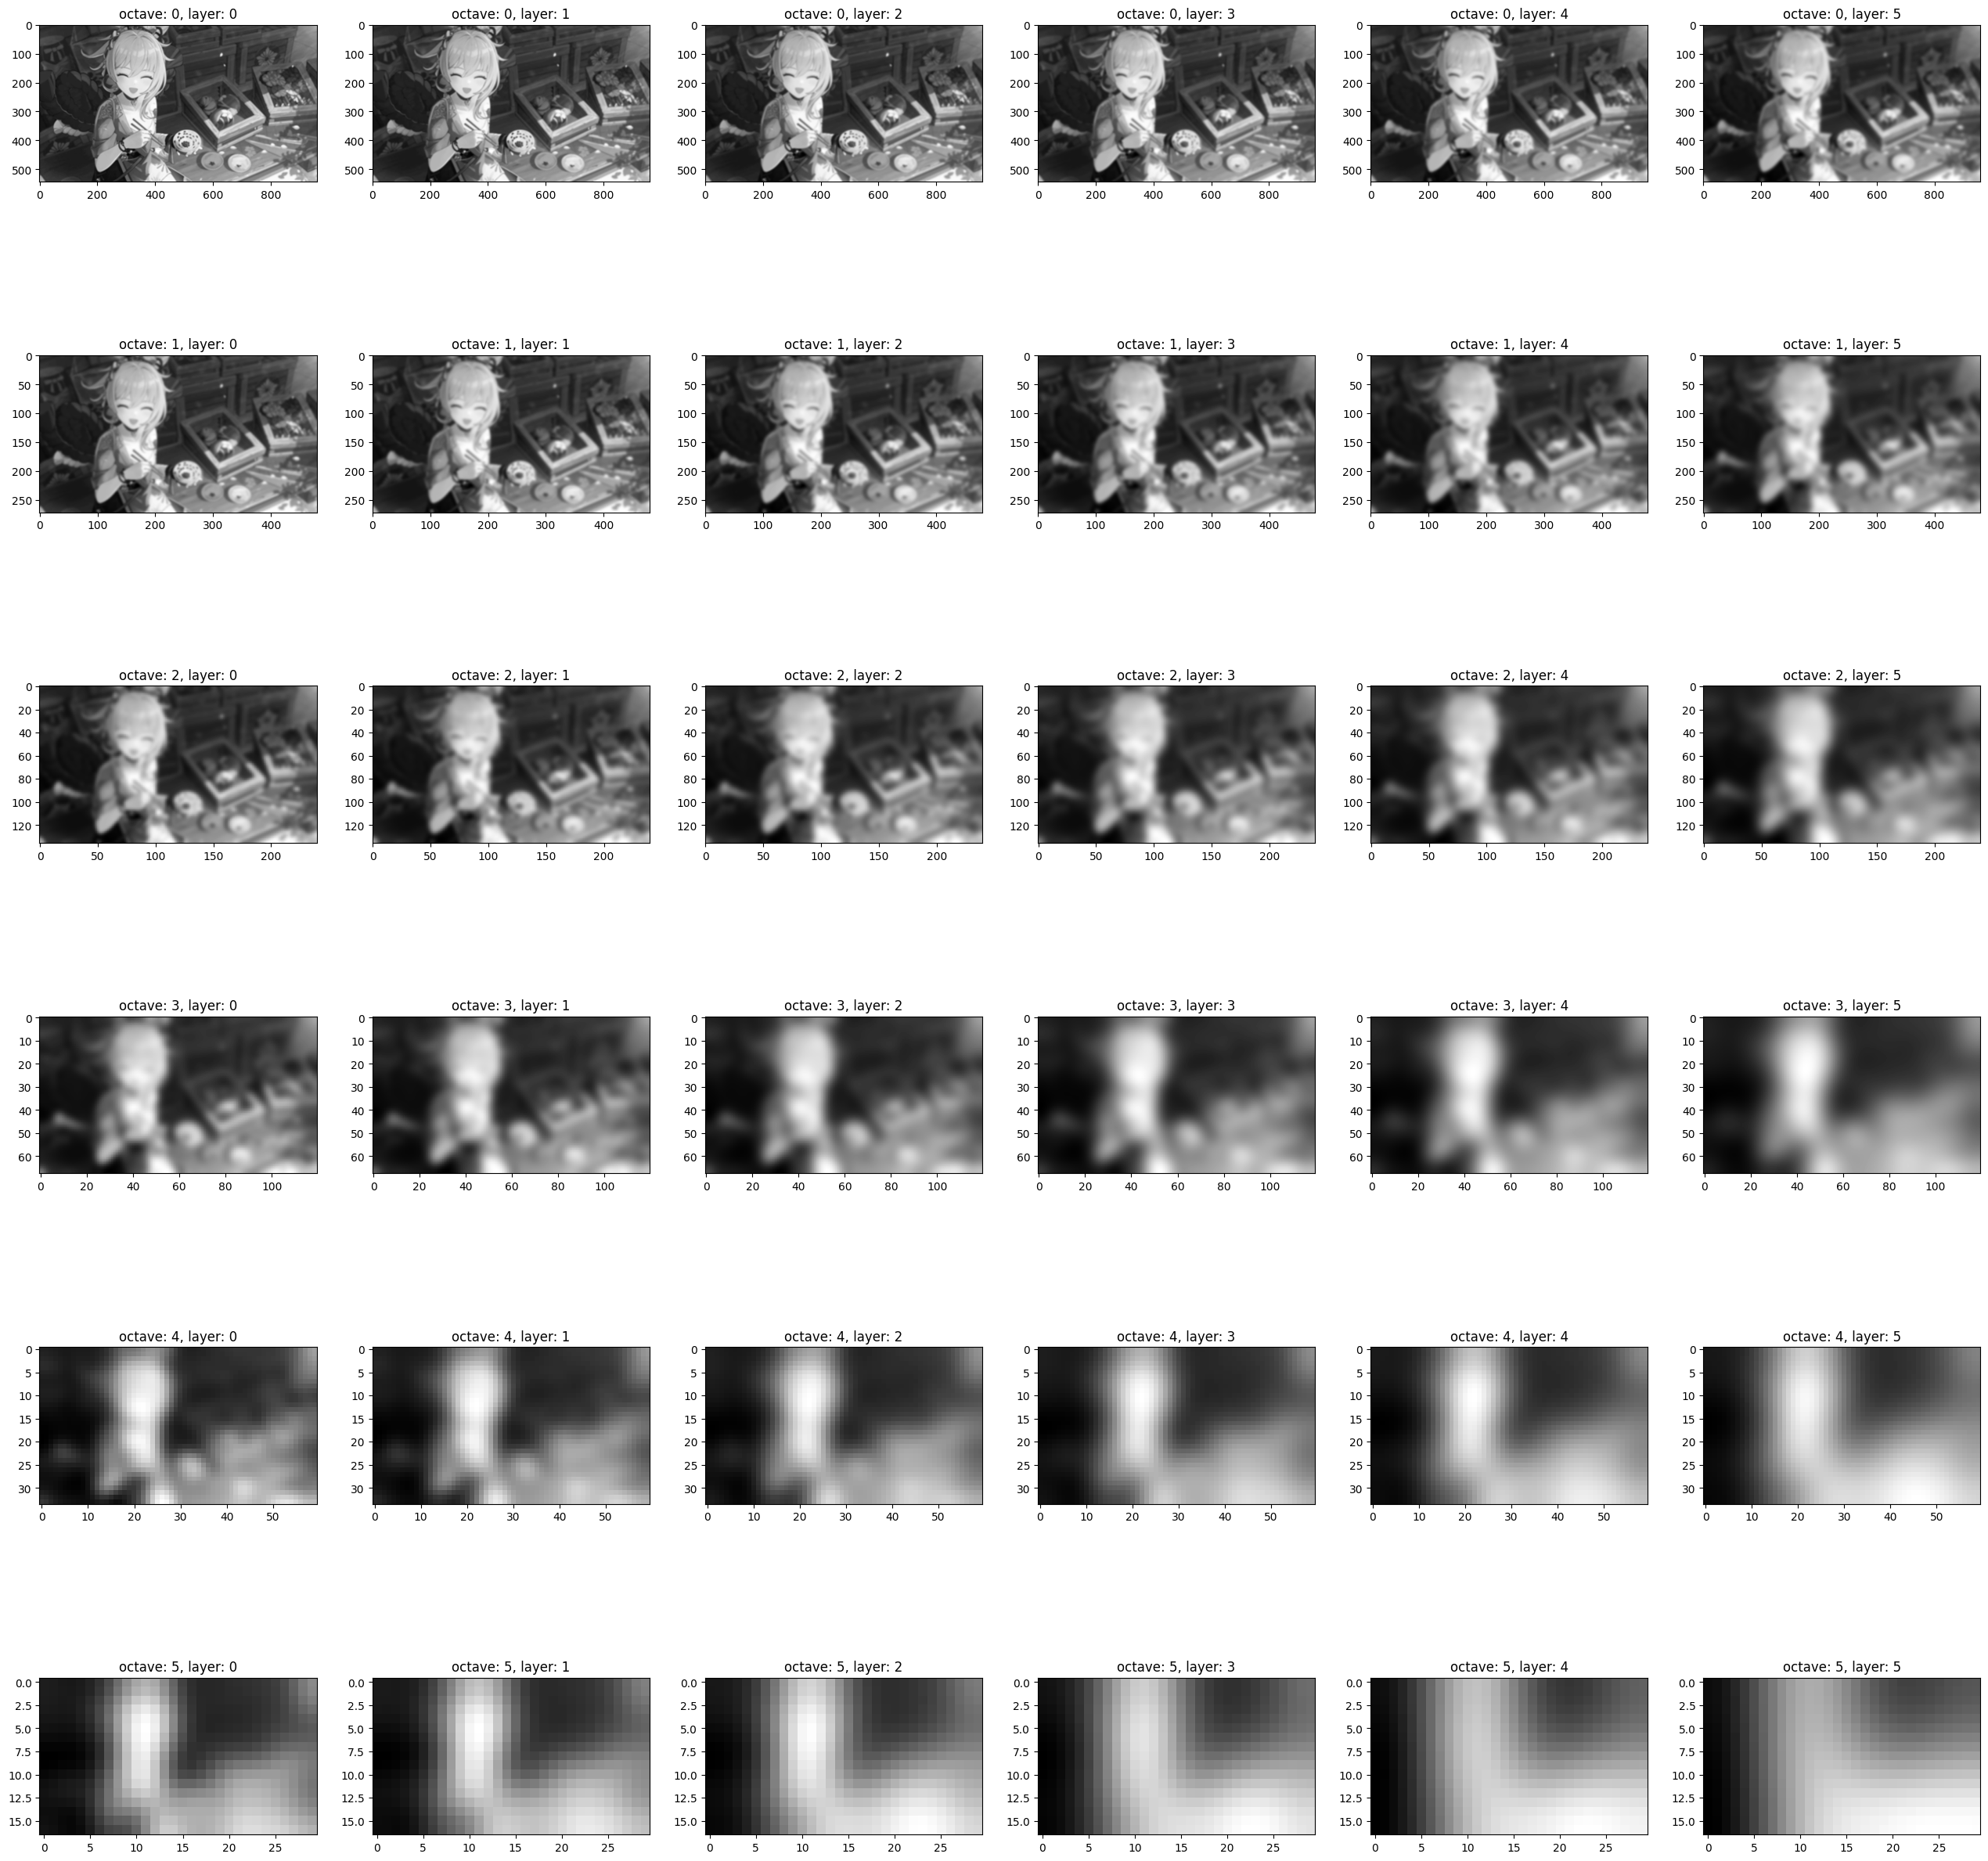

In [291]:
plt.figure(figsize=(32, 32))
for i in range(num_octaves):
    for j in range(len(gaussian_imgs[i])):
        plt.subplot(num_octaves, len(gaussian_imgs[i]), i * len(gaussian_imgs[i]) + j + 1, aspect='equal')
        plt.imshow(gaussian_imgs[i][j], cmap='gray')
        plt.title(f"octave: {i}, layer: {j}")
plt.savefig("gaussian_images.png")

## 1.2 构建DoG金字塔
1. 接下来构建高斯差分金字塔。高斯差分金字塔与高斯金字塔结构一致，生成过程是用高斯金字塔每一组内的两幅图像差分生成。公式是：
$$D(x,y,\sigma) = (G(x,y,k\sigma) -G(x,y,\sigma)) * I(x,y) = L(x,y,k\sigma) - L(x,y,\sigma)$$
论文中也给出了相应的示意图，DOG图像描绘的是目标的轮廓。
![论文中的示意图](./img/1.png)

In [292]:
def GenerateDoGImages(gaussian_img):
    """Generate Difference-of-Gaussians image pyramid
    """
    DoG_images = []
    for img in gaussian_img:
        dog_images_in_octave = []
        for st, nd in zip(img, img[1:]):
            # 这里使用cv.subtract()函数，而不是nd - st
            dog_images_in_octave.append(cv.subtract(nd, st))
        DoG_images.append(dog_images_in_octave)
    return np.array(DoG_images, dtype=object)

In [293]:
DoG_imgs = GenerateDoGImages(gaussian_imgs)

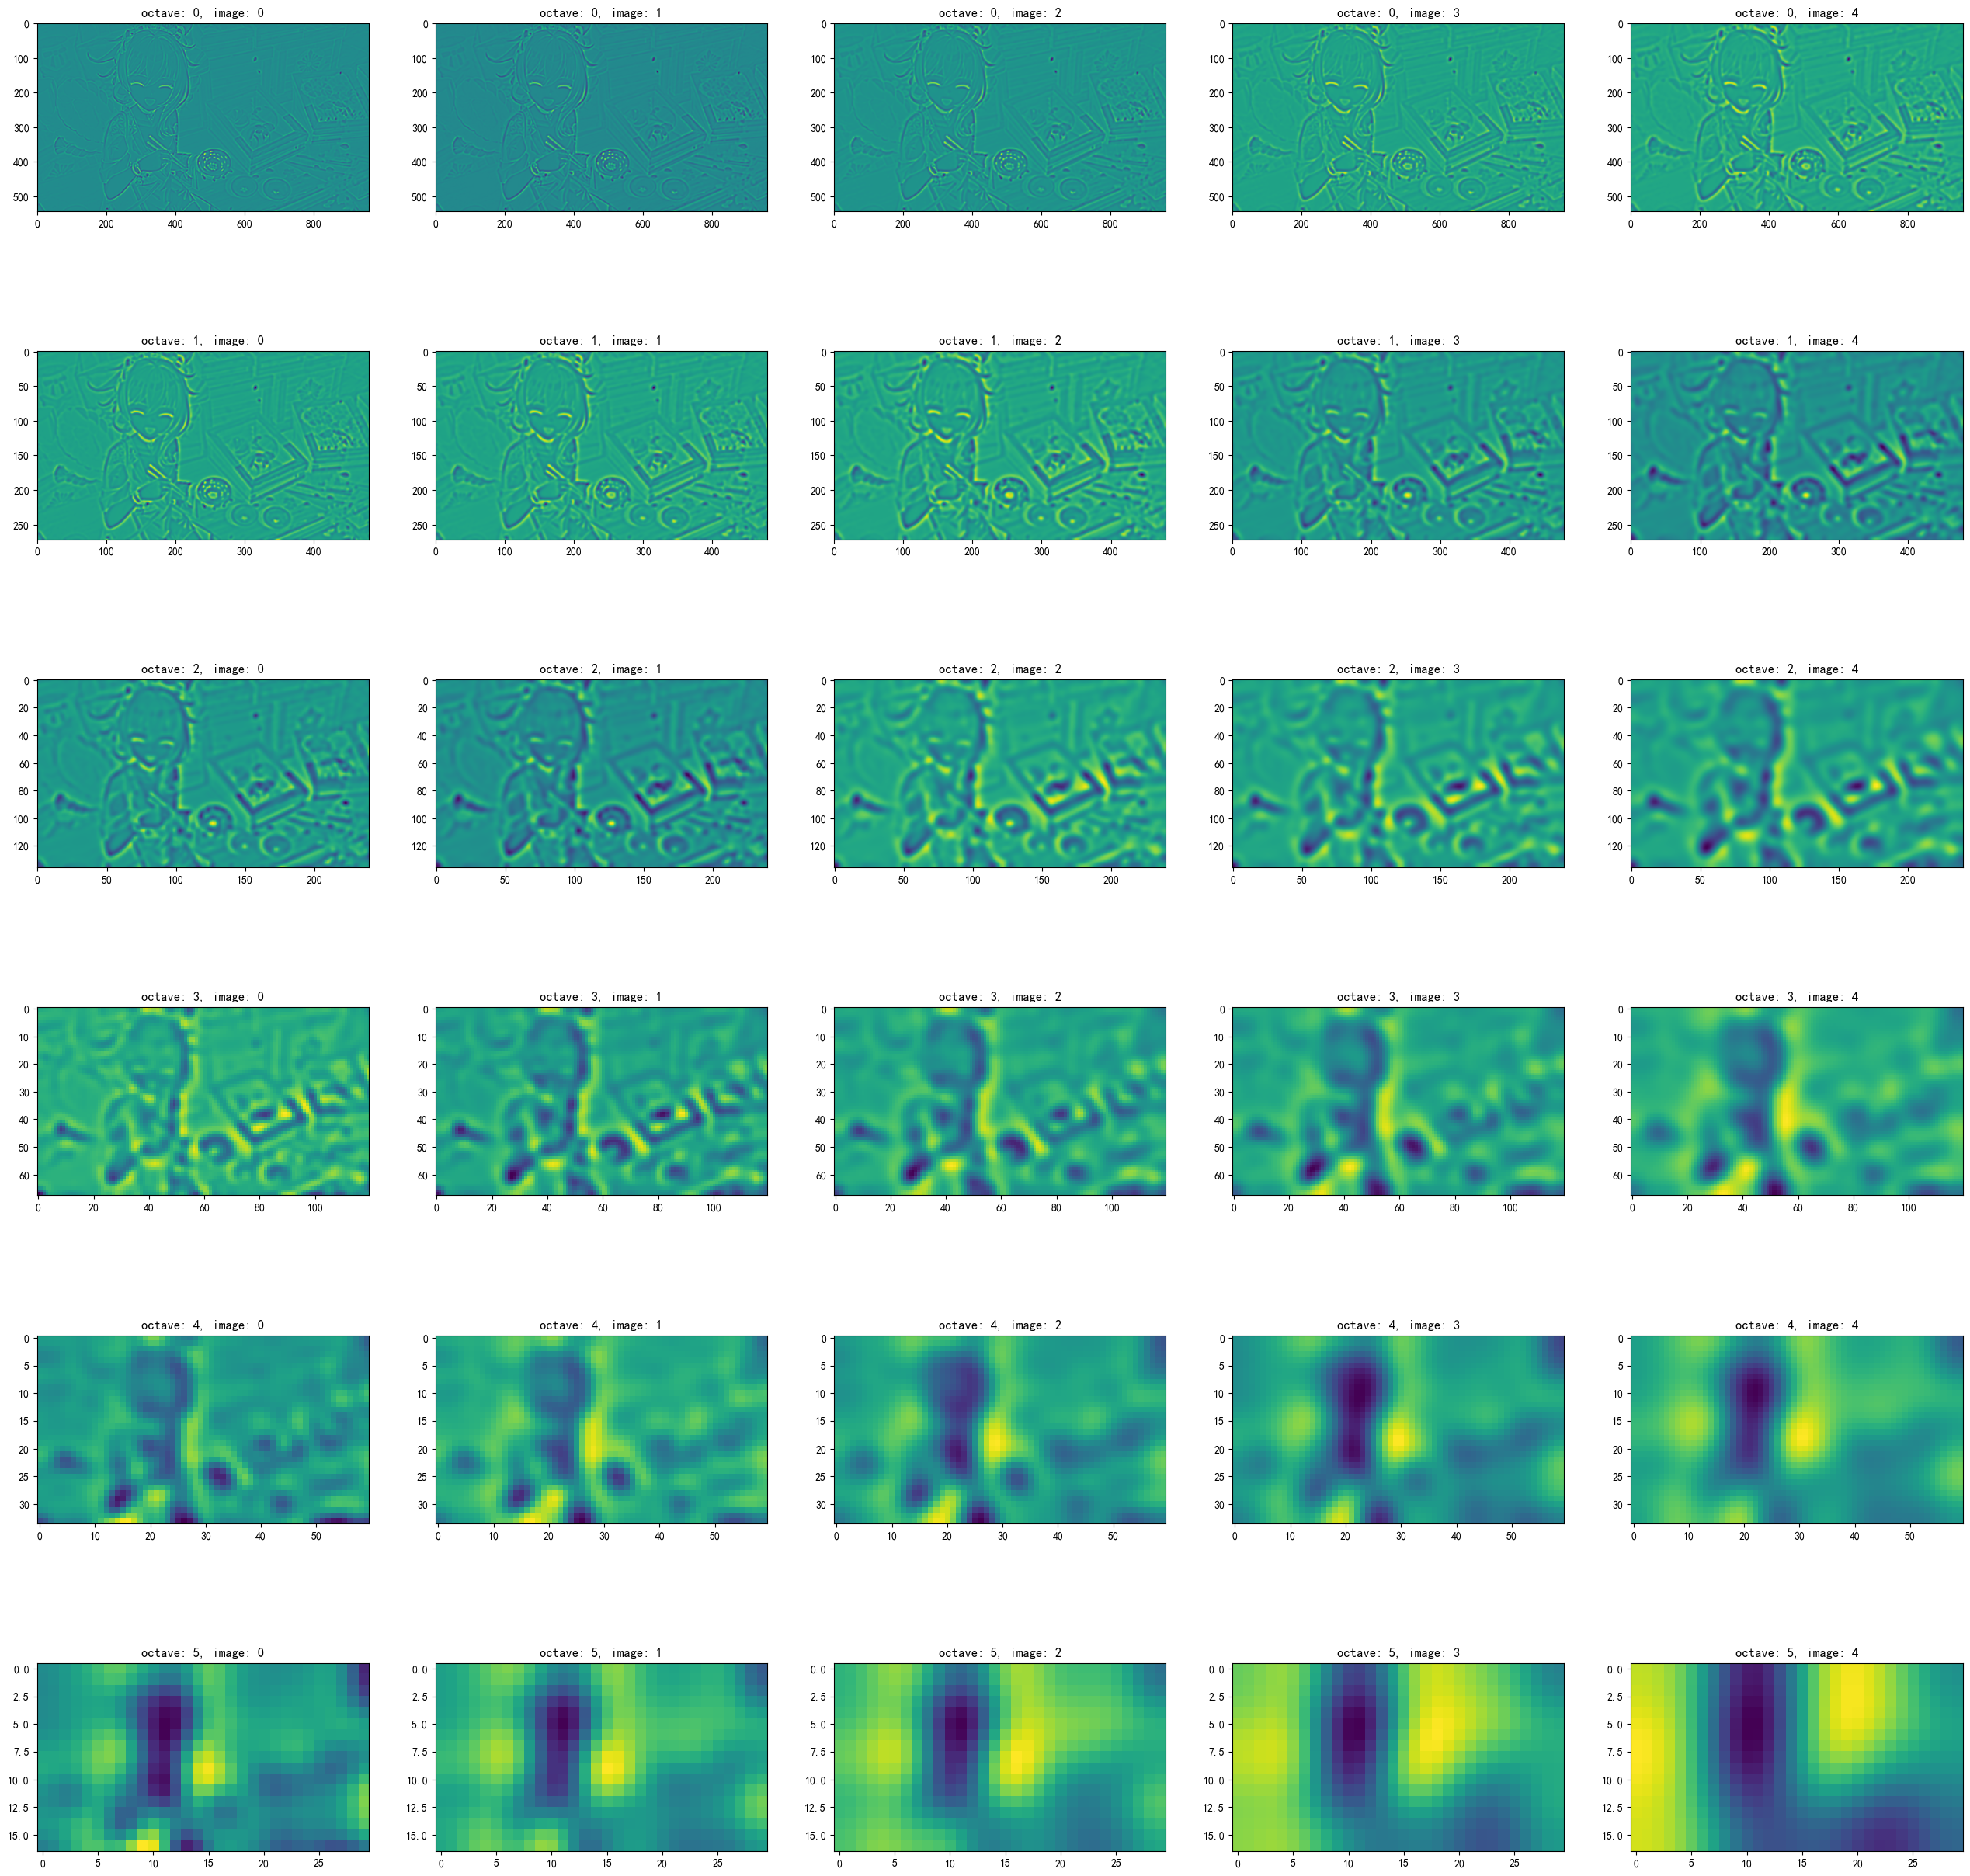

In [365]:
plt.figure(figsize=(32, 32))
for octave_index in range(num_octaves):
    for layer_index in range(len(DoG_imgs[octave_index])):
        plt.subplot(num_octaves, len(DoG_imgs[octave_index]), octave_index * len(DoG_imgs[octave_index]) + layer_index + 1, aspect='equal')
        plt.imshow(DoG_imgs[octave_index][layer_index])
        plt.title(f"octave: {octave_index}, image: {layer_index}")
plt.savefig("dog_images.png")
plt.show()


# 2. 构建空间极值点
## 2.1 局部极值点的检测（Local extrema detection）
1. 极值点的选取是SIFT算法的核心。论文中提到，极值点的选取是通过对DOG图像进行极值点的选取，然后再对DOG图像进行插值，得到更精确的极值点。这里先来看看局部极值点的选取。
2. 选取取方法为将一个像素与其周围的26个相邻像素进行比较，如果该像素取到最大值或最小值，那么这就是一个极值点。（$26=8+9*2$它同尺度的8个相邻点和上下相邻尺度对应9×2个点共26个点）。由于要在相邻尺度进行比较，那么一个每组含4层的高斯差分金子塔，只能在中间两层中进行两个尺度的极值点检测，其它尺度则只能在不同组中进行。为了在每组中检测S个尺度的极值点，则DoG金字塔每组需S+2层图像，而DoG金字塔由高斯金字塔相邻两层相减得到，所以高斯金字塔每组需S+3层图像，实际计算时S在3~5之间。
3. 为了实际检测的稳定性以及方便，每层中实际比较的区域为(M-SIFT_IMG_BORDER)*(N-SIFT_IMG_BORDER),其中我在代码中设定了SIFT_IMG_BORDER = 5，即每层图像的边界为5个像素不参与比较。
4. 具体到代码中把连续的一个Octave中的三张DOG图像进行了zip，只需直接选取中间那张3x3的图像的中心点即可。另外有一个先决条件就是，由于过小的点易受噪声的干扰而变得不稳定，所以将小于某个经验值(Lowe论文中使用0.03（For the experiments in this paper, all extrema with a value of $|D(\hat{x})|$ less than 0.03 were discarded (as before, we assume image pixel values in the range [0,1]).）)的极值点删除，但是实际上在后续的优化以及opencv的实现中采用的是$0.04/s$这个值去作为阈值，其中s是尺度空间的层数，这里我们设定的是3，并且我们的像素是[0,255]，所以阈值为 CONTRAST_THRESHOLD = round(0.04/3 * 255) = 1,及为小于1的像素点直接不考虑。
![论文中的示意图](./img/6.jpg)




*************octave: 0*************
cnt_local_extrema: 29
cnt_local_extrema: 3


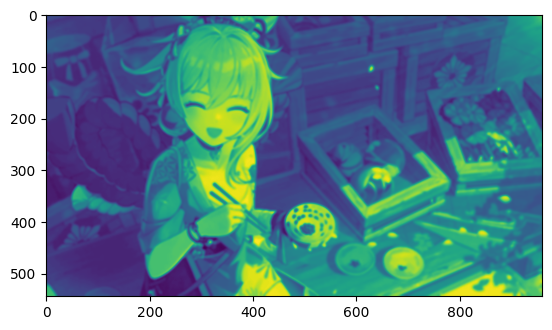

In [317]:
# ########################DEBUG#########################
# import warnings
#
# warnings.filterwarnings("ignore")
# def isPixelAnExtremum(st, nd, rd, threshold):
#     """
#     根据3x3x3的数组判断中心点是否是极值点，如果是极值点则返回True，否则返回False，并且极值点的阈值为threshold
#     """
#     c = nd[1, 1]
#     # 把这个3x3x3的矩阵展开成一个一维数组，然后找出最大值和最小值
#     if abs(c) > threshold:
#         if c > 0:
#             return np.all(c >= st) and np.all(c >= rd) and np.all(c >= nd[0, :]) and np.all(c >= nd[2, :]) and c >= nd[1, 0] and c >= nd[1, 2]
#         elif c < 0:
#             return np.all(c <= st) and np.all(c <= rd) and np.all(c <= nd[0, :]) and np.all(c <= nd[2, :]) and c <= nd[1, 0] and c <= nd[1, 2]
#     return False
# import time
# start = time.time()
# cnt_local_extrema = 0
# cnt_accruate_keypoints = 0
# flag = False
# draw_num = 0
# # plt.figure(figsize=(50, 50))
# for octave_index, DoG_imgs_in_octave in enumerate(DoG_imgs):
#     threshold = np.floor(0.5 * CONTRAST_THRESHOLD / NUM_INTVLS * 255)
#     print(f"\n*************octave: {octave_index}*************")
#     three_zip_image = zip(DoG_imgs_in_octave, DoG_imgs_in_octave[1:], DoG_imgs_in_octave[2:])
#     for layer_index, img_truple in enumerate(three_zip_image):
#         # print(f"------------------octave: {octave_index}, layer: {image_index}------------------")
#         # 遍历图像进行比较
#         for i in range(IMAGE_BORDER_WIDTH, img_truple[0].shape[0] - IMAGE_BORDER_WIDTH):
#             for j in range(IMAGE_BORDER_WIDTH, img_truple[0].shape[1] - IMAGE_BORDER_WIDTH):
#                     # 判断是否是局部极值点
#                 if IsLocalExtrema(*(Find3x3x3Cube(*(img_truple), i, j)), threshold):
#                     cnt_local_extrema += 1
#                     local_extrema = IsAccurateKeyPoints(i, j, layer_index + 1, octave_index, DoG_imgs_in_octave)
#                     if local_extrema is not None:
#                         draw_num += 1
#                         cnt_accruate_keypoints += 1
#                         # 方向分配
#                         keypoint, local_layer_index = local_extrema
#                         cal_img = gaussian_imgs[octave_index][local_layer_index]
#                         # plt.imshow(gaussian_imgs)
#                         # 测试方向直方图
#                         # keypoints_with_orientations,temp_raw_hist,temp_smooth_hist = AssignOrientationToKeypoints(keypoint, octave_index, cal_img)
#                         # if cnt_accruate_keypoints > 9:
#                         #     break
#                         # plt.subplot(10, 10, cnt_accruate_keypoints)
#                         keypoints_with_orientations = AssignOrientationToKeypoints(keypoint, octave_index, cal_img)
#                         flag = True
#             if cnt_accruate_keypoints > 2:
#                 break
#         break
#     break
# end = time.time()
# # plt.savefig("./img/方向图100.jpg")
# # 计算出空间中的所有局部极值点
# print(f"cnt_local_extrema: {cnt_local_extrema}")
# print(f"cnt_local_extrema: {cnt_accruate_keypoints}")

In [ ]:
######### DEBUG绘制直方图DEBUG
# print(f"max:{max(temp_raw_hist)}, min:{min(temp_raw_hist)}")
# print(f"max:{max(temp_smooth_hist)}, min:{min(temp_smooth_hist)}")
# temp_raw_hist_log = np.array(temp_raw_hist) + 1
# temp_smooth_hist_log = np.array(temp_smooth_hist) + 1
# # 给数据取对数，但是有些数据为0，所以需要加上一个极小值
# temp_raw_hist_log = np.log(temp_raw_hist_log) + 1
# temp_smooth_hist_log = np.log(temp_smooth_hist_log) + 1
# plt.figure(figsize=(15, 5))
# plt.subplot(1, 2, 1)
# plt.bar(range(len(temp_raw_hist)), temp_raw_hist_log)
# plt.title("raw hist with log")
# plt.xticks(range(len(temp_smooth_hist)), range(0, 360, 10), rotation=80)
# plt.ylabel('Log Value')
# plt.xlabel('bins')
# plt.subplot(1, 2, 2)
# plt.bar(range(len(temp_smooth_hist)), temp_smooth_hist_log)
# plt.ylabel('Log Value')
# plt.xlabel('bins')
# plt.xticks(range(len(temp_smooth_hist)), range(0, 360, 10), rotation=80)
# plt.title("smooth hist with log")
# plt.savefig("./img/smooth_hist.png")
# plt.show()
######### DEBUG绘制直方图DEBUG

## 2.2 极值点的精确化（Accurate keypoint localization）
上面的极值点表示的是离散空间中的极值点，但是实际上我们需要求出的是连续空间的极值点，同时还要去除低对比度的关键点和不稳定的边缘响应点(因为DoG算子会产生较强的边缘响应)，以增强匹配稳定性、提高抗噪声能力。
### 2.2.1 找寻连续尺度空间中的极值点
1. 子像素插值法：首先我们从数学角度进行分析，对于任意一个极值点，我们要考虑他在连续空间中仍然是否为极值点，而且这里的连续是一个空间状态而非一个二维的线段，所以要使用的是子像素插值法（Sub-pixel Interpolation）DoG图像（DoG函数）：对应的是函数$f$；DoG中的每一个像素值对应的是$f_{(x,y, \sigma)}$,极值点在离散空间的坐标为$(x_0,y_0,\sigma_0)$，那么我们可以得到DOG的泰勒展开（只取前三项）：
$$
f_{([\mathrm{x}, \mathrm{y}, \sigma])}=\mathrm{f}_{\left[\mathrm{x}_0, \mathrm{y}_0, \sigma_0\right]}+\left[\frac{\partial \mathrm{f}}{\partial \mathrm{x}}, \frac{\partial \mathrm{f}}{\partial \mathrm{y}}, \frac{\partial \mathrm{f}}{\partial \sigma}\right]\left(\left[\begin{array}{c}
\mathrm{x} \\
\mathrm{y} \\
\sigma
\end{array}\right]-\left[\begin{array}{c}
\mathrm{x}_0 \\
\mathrm{y}_0 \\
\sigma_0
\end{array}\right]\right)+\frac{1}{2}\left([\mathrm{x}, \mathrm{y}, \sigma]-\left[\mathrm{x}_0, \mathrm{y}_0, \sigma_0\right]\right)\left[\begin{array}{ccc}
\frac{\partial^2 \mathrm{f}}{\partial \mathrm{x}^2} & \frac{\partial^2 \mathrm{f}}{\partial \mathrm{x} \partial \mathrm{y}} & \frac{\partial^2 \mathrm{f}}{\partial \mathrm{x} \partial \sigma} \\
\frac{\partial^2 \mathrm{f}}{\partial \mathrm{x} \partial \mathrm{y}} & \frac{\partial^2 \mathrm{f}}{\partial \mathrm{y}^2} & \frac{\partial^2 \mathrm{f}}{\partial \mathrm{y} \partial \sigma} \\
\frac{\partial^2 \mathrm{f}}{\partial \mathrm{x} \partial \sigma} & \frac{\partial^2 \mathrm{f}}{\partial \mathrm{y} \partial \sigma} & \frac{\partial^2 \mathrm{f}}{\partial \sigma^2}
\end{array}\right]
\left(\left[\begin{array}{l}
\mathrm{x} \\
\mathrm{y} \\
\sigma
\end{array}\right]-\left[\begin{array}{l}
\mathrm{x}_0 \\
\mathrm{y}_0 \\
\sigma_0
\end{array}\right]\right)
$$
记$\mathrm{X}=\left[\begin{array}{l}\mathrm{x} \\ \mathrm{y} \\ \sigma\end{array}\right], \mathrm{X}_0=\left[\begin{array}{l}\mathrm{x}_0 \\ \mathrm{y}_0 \\ \sigma_0\end{array}\right], \mathrm{D}=\mathrm{f}$则可以简写公式为：
$$
\mathrm{D}_{(\mathrm{X})}=\mathrm{D}_{\left(\mathrm{X}_0\right)}+\frac{\partial \mathrm{D}}{\partial \mathrm{X}_0}\left(\mathrm{X}-\mathrm{X}_0\right)+\frac{1}{2} \frac{\partial^2 \mathrm{D}}{\partial \mathrm{X}_0^2}\left(\mathrm{X}-\mathrm{X}_0\right)^2
$$
由于我们想计算的是真实的极值点的一个偏移量，所以我们考虑让$\mathrm{X}_0=0$，则有：
$$
\mathrm{D}_{(\mathrm{X})}=\mathrm{D}_{\left(\mathrm{X}_0\right)}+\frac{\partial \mathrm{D}}{\partial \mathrm{X}_0} \mathrm{X}+\frac{1}{2} \frac{\partial^2 \mathrm{D}}{\partial \mathrm{X}_0^2} \mathrm{X}^2
$$
之后我们只需要求导让方程等于0即可：
$$
\begin{aligned}
& \frac{\partial \mathrm{D}}{\partial \mathrm{X}_0}+\frac{\partial^2 \mathrm{D}}{\partial \mathrm{X}_0^2} \mathrm{X}=0 \\
& \hat{\mathrm{X}}=-\left(\frac{\partial^2 \mathrm{D}}{\partial \mathrm{X}_0^2}\right)^{-1} \frac{\partial \mathrm{D}}{\partial \mathrm{X}_0}
\end{aligned}
$$
其中有二阶导数由Heassian矩阵表示：
$$
\begin{gathered}
\frac{\partial \mathrm{D}}{\partial \mathrm{X}_0}=\left[\begin{array}{lll}
\frac{\partial \mathrm{D}}{\partial \mathrm{x}_0}, \frac{\partial \mathrm{D}}{\partial \mathrm{y}_0}, \frac{\partial \mathrm{D}}{\partial \sigma_0}
\end{array}\right] \\
\frac{\partial^2 \mathrm{D}}{\partial \mathrm{X}_0^2}=\left[\begin{array}{ccc}
\frac{\partial^2 \mathrm{D}}{\partial \mathrm{x}^2} & \frac{\partial^2 \mathrm{D}}{\partial \mathrm{x} \partial \mathrm{y}} & \frac{\partial^2 \mathrm{D}}{\partial \mathrm{x} \partial \sigma} \\
\frac{\partial^2 \mathrm{D}}{\partial \mathrm{x} \partial \mathrm{y}} & \frac{\partial^2 \mathrm{D}}{\partial \mathrm{y}^2} & \frac{\partial^2 \mathrm{D}}{\partial \mathrm{y} \partial \sigma} \\
\frac{\partial^2 \mathrm{D}}{\partial \mathrm{x} \partial} & \frac{\partial^2 \mathrm{D}}{\partial \mathrm{y} \partial \sigma} & \frac{\partial^2 \mathrm{D}}{\partial \sigma^2}
\end{array}\right]
\end{gathered}
$$
这里由于点在空间中是离散的，所以求导的过程我们使用差分替代
$$
\begin{aligned}
& \frac{\partial \mathrm{D}}{\mathrm{x}_0}=\frac{\mathrm{D}_{(\mathrm{x}+1, \mathrm{y}, \mathrm{\sigma})}-\mathrm{D}_{(\mathrm{x}-1, \mathrm{y}, \mathrm{\sigma})}}{2} \\
& \frac{\partial \mathrm{D}}{\mathrm{y}_0}=\frac{\mathrm{D}_{(\mathrm{x}, \mathrm{y}+1, \mathrm{\sigma})}-\mathrm{D}_{(x, y-1, \mathrm{\sigma})}}{2} \\
& \frac{\partial \mathrm{D}}{\sigma_0}=\frac{\mathrm{D}_{(x, y, \sigma+1)}-\mathrm{D}_{(x, y, \sigma-1)}}{2} \\
& \frac{\partial^2 \mathrm{D}}{\mathrm{x}_0^2}=\mathrm{D}_{(\mathrm{x}+1, \mathrm{y}, \mathrm{\sigma})}-2 \mathrm{D}_{(x, y, \sigma)}+\mathrm{D}_{(x-1, y, \sigma)} \\
& \frac{\partial^2 \mathrm{D}}{\mathrm{y}_0^2}=\mathrm{D}_{(x, y+1, \sigma)}-2 \mathrm{D}_{(x, y, \sigma)}+\mathrm{D}_{(x, y-1, \sigma)} \\
& \frac{\partial^2 \mathrm{D}}{\sigma_0^2}=\mathrm{D}_{(x, y, \sigma+1)}-2 \mathrm{D}_{(x, y, \sigma)}+\mathrm{D}_{(x, y, \sigma)} \\
& \frac{\partial^2 \mathrm{D}}{\mathrm{x}_0 \mathrm{y}_0}=\frac{\mathrm{D}_{(\mathrm{x}+1, \mathrm{y}+1, \sigma)}-\mathrm{D}_{(\mathrm{x}+1, \mathrm{y}-1, \sigma)}-\mathrm{D}_{(\mathrm{x}-1, \mathrm{y}+1, \sigma)}+\mathrm{D}_{(\mathrm{x}-1, \mathrm{y}-1, \sigma)}}{4} \\
& \frac{\partial^2 \mathrm{D}}{\mathrm{x}_0 \sigma_0}=\frac{\mathrm{D}_{(\mathrm{x}+1, \mathrm{y}, \sigma+1)}-\mathrm{D}_{(\mathrm{x}+1, \mathrm{y}, \sigma-1)}-\mathrm{D}_{(\mathrm{x}-1, \mathrm{y}, \mathrm{\sigma}+1)}+\mathrm{D}_{(\mathrm{x}-1, \mathrm{y}, \sigma-1)}}{4} \\
& \frac{\partial^2 \mathrm{D}}{\mathrm{y}_0 \sigma_0}=\frac{\mathrm{D}_{(x, y+1, \sigma+1)}-\mathrm{D}_{(x, y+1, \sigma-1)}-\mathrm{D}_{(x, y-1, \sigma+1)}+\mathrm{D}_{(x, y-1, \sigma-1)}}{4} \\
&
\end{aligned}
$$
2. 这样我们就可以求出偏移量$\hat{\mathrm{X}}$，注意在实际代码中求解$\frac{\partial \mathrm{D}}{\partial \mathrm{X}_0}+\frac{\partial^2 \mathrm{D}}{\partial \mathrm{X}_0^2} \mathrm{X}=0$时我采用的是numpy的`lstsq`线性方程求解，这样可以避免矩阵求逆的过程，提高运算速度。
3. 求出$\hat{\mathrm{X}}$后，我们认为如果他在任意一个维度的偏移量大于0.5，那么就认为这个点已经偏移到了另一个像素点上，这时候我们就认为这个点不是极值点，所以必须更新关键点的位置。然后在新的位置上反复插值直到收敛直到偏移量都小于0.5或者迭代更新到`NUM_ATTMEPT_UNTIL_CONVERFENCE`（论文中设置的为5）为止。
4. 同时我们仍然需要保证插值计算后的点在图像的边界内，并且要小于`CONTRAST_THRESHOLD`
5. 最后得到更新后的极值点处的像素为：
$$
\mathrm{D}_{\hat{\mathrm{X}}}=\mathrm{D}_{\mathrm{X}_0}+\frac{1}{2} \frac{\partial \mathrm{D}}{\partial \mathrm{X}_0} \hat{\mathrm{X}}
$$

In [342]:
def FindAllKeyPoints(gaussian_imgs, DoG_imgs):
    """
    在图像金字塔中找到所有尺度空间极值点的像素位置
    """
    threshold = np.floor(0.5 * CONTRAST_THRESHOLD / NUM_INTVLS * 255)  # from OpenCV implementation
    keypoints = []
    cnt_local_extrema = 0
    cnt_accruate_keypoints = 0
    for octave_index, DoG_imgs_in_octave in enumerate(DoG_imgs):
        # 将DOG图像中的三张图像进行zip，然后取中间那张图像的中心点进行比较
        three_zip_img = zip(DoG_imgs_in_octave, DoG_imgs_in_octave[1:], DoG_imgs_in_octave[2:])
        for layer_index, img_truple in enumerate(three_zip_img):
            # 遍历图像进行比较
            for i in range(IMAGE_BORDER_WIDTH, img_truple[0].shape[0] - IMAGE_BORDER_WIDTH):
                for j in range(IMAGE_BORDER_WIDTH, img_truple[0].shape[1] - IMAGE_BORDER_WIDTH):
                    # 判断是否是局部极值点
                    if IsLocalExtrema(*(Find3x3x3Cube(*(img_truple), i, j)), threshold):
                        cnt_local_extrema += 1
                        local_extrema = IsAccurateKeyPoints(i, j, layer_index + 1, octave_index, DoG_imgs_in_octave)
                        if local_extrema is not None:
                            cnt_accruate_keypoints += 1
                            # 方向分配
                            keypoint, local_layer_index = local_extrema
                            cal_img = gaussian_imgs[octave_index][local_layer_index]
                            keypoints_with_orientations = AssignOrientationToKeypoints(keypoint, octave_index,cal_img)
                            for kk in keypoints_with_orientations:
                                keypoints.append(kk)
    # print(f"cnt_local_extrema: {cnt_local_extrema}")
    # print(f"cnt_local_extrema: {cnt_accruate_keypoints}")
    return keypoints


def FindAllKeyPointsMuti(gaussian_imgs, DoG_imgs):
    """
    在图像金字塔中找到所有尺度空间极值点的像素位置
    """
    keypoints_list = []
    threshold = np.floor(0.5 * CONTRAST_THRESHOLD / NUM_INTVLS * 255)  # from OpenCV implementation
    cnt_local_extrema = 0
    cnt_accruate_keypoints = 0
    args = []
    for octave_index, DoG_imgs_in_octave in enumerate(DoG_imgs):
        # 将DOG图像中的三张图像进行zip，然后取中间那张图像的中心点进行比较
        three_zip_img = zip(DoG_imgs_in_octave, DoG_imgs_in_octave[1:], DoG_imgs_in_octave[2:])
        for layer_index, img_truple in enumerate(three_zip_img):
            # 遍历图像进行比较
            for i in range(IMAGE_BORDER_WIDTH, img_truple[0].shape[0] - IMAGE_BORDER_WIDTH):
                for j in range(IMAGE_BORDER_WIDTH, img_truple[0].shape[1] - IMAGE_BORDER_WIDTH):
                    args.append((i,j,img_truple,threshold,octave_index,layer_index,gaussian_imgs,DoG_imgs_in_octave))
    print(len(args))
    pool = Pool(processes=8)
    results = pool.starmap(MutiTask, args)
    pool.close()
    pool.join()
    for result in results:
        if result is not None:
            for kk in result:
                keypoints_list.append(kk)
    print(f"cnt_local_extrema: {cnt_local_extrema}")
    print(f"cnt_local_extrema: {cnt_accruate_keypoints}")
    return keypoints_list
def MutiTask(i,j,img_truple,threshold,octave_index,layer_index,gaussian_imgs,DoG_imgs_in_octave):
    """
    """
    if IsLocalExtrema(*(Find3x3x3Cube(*(img_truple), i, j)), threshold):
        # cnt_local_extrema += 1
        local_extrema = IsAccurateKeyPoints(i, j, layer_index + 1, octave_index, DoG_imgs_in_octave)
        if local_extrema is not None:
            # cnt_accruate_keypoints += 1
            # 方向分配
            keypoint, local_layer_index = local_extrema
            cal_img = gaussian_imgs[octave_index][local_layer_index]
            keypoints_with_orientations = AssignOrientationToKeypoints(keypoint, octave_index,cal_img)
            return keypoints_with_orientations
    return None

def Find3x3x3Cube(st, nd, rd, i, j):
    """
    从3xoctxlayer的zip图像中取出中心点的3x3x3的img Grid
    """
    return st[i-1:i+2,j-1:j+2],\
           nd[i-1:i+2,j-1:j+2],\
           rd[i-1:i+2,j-1:j+2]

def IsLocalExtrema(st, nd, rd, threshold):
    """
    根据3x3x3的数组判断中心点是否是极值点，如果是极值点则返回True，否则返回False，并且极值点的阈值为threshold
    """
    c = nd[1, 1]
    # 把这个3x3x3的矩阵展开成一个一维数组，然后找出最大值和最小值
    if abs(c) > threshold:
        if c > 0:
            return np.all(c >= st) and np.all(c >= rd) and np.all(c >= nd[0, :]) and np.all(c >= nd[2, :]) and c >= nd[1, 0] and c >= nd[1, 2]
        elif c < 0:
            return np.all(c <= st) and np.all(c <= rd) and np.all(c <= nd[0, :]) and np.all(c <= nd[2, :]) and c <= nd[1, 0] and c <= nd[1, 2]
    return False

def IsOutOfBorder(img, i, j, layer_index):
    """
    判断像素点是否在图像边界之外
    """
    if i < IMAGE_BORDER_WIDTH or i >= img[0] - IMAGE_BORDER_WIDTH or \
       j < IMAGE_BORDER_WIDTH or j >= img[1] - IMAGE_BORDER_WIDTH or \
       layer_index < 1 or layer_index > NUM_INTVLS:
        return True
    return False

def IsAccurateKeyPoints(i, j, layer_index, octave_index, DoG_imgs_in_octave):
    """
    通过对每个极值点的邻域进行二次拟合来迭代地改进尺度空间极值点的像素位置
    """
    is_out_imgs = False
    # cnt_attempt = 0
    for cnt_attempt in range(NUM_ATTMEPT_UNTIL_CONVERFENCE): # 5次迭代
        # 将像素值缩放到[0,1]来应用Lowe的阈值
        img_cube = Find3x3x3Cube(*(DoG_imgs_in_octave[layer_index - 1:layer_index + 2]), i, j)
        pixel_cube = np.stack([*(img_cube)]).astype('float32') / 255.
        # 计算该cube的dD/dx,dD/dy,dD/d(sigma),返回为列向量dD/dX
        gradient = GetFirstDifference(pixel_cube)
        # 用离散值近似计算出三维hessian矩阵,即公式中d2D/dX2
        hessian = GetSecondDifference(pixel_cube)
        # 解方程组,返回的回归系数、残差平方和、自变量X的秩、X的奇异值，我们只需要回归系数即可
        X_hat = -np.linalg.lstsq(hessian, gradient, rcond=None)[0]
        # 如果回归系数的绝对值都小于0.5，则认为该点已经收敛，否则继续迭代
        if abs(X_hat[0]) < 0.5 and abs(X_hat[1]) < 0.5 and abs(X_hat[2]) < 0.5:
            break
        j += int(round(X_hat[0]))
        i += int(round(X_hat[1]))
        layer_index += int(round(X_hat[2]))
        # 确保插值后的pixel_cube完全位于图像内
        is_out_imgs = IsOutOfBorder(DoG_imgs_in_octave[0].shape, i, j, layer_index)
        if is_out_imgs:
            break
    # 超出边界，或者迭代次数超过5次，或者像素点超出图像边界
    if is_out_imgs or cnt_attempt >= NUM_ATTMEPT_UNTIL_CONVERFENCE - 1:
        return None
    # 最后得到更新后的极值点,带入一阶泰勒展开
    pix_x_hat = pixel_cube[1, 1, 1] + 0.5 * np.dot(gradient, X_hat)
    # 消除边缘效应
    # 首先要保证该点仍然大于阈值
    if abs(pix_x_hat) * NUM_INTVLS >= CONTRAST_THRESHOLD:
        # 计算曲率，首先获得hessian矩阵的前两行两列，计算矩阵的迹和行列式
        xy_hessian = hessian[:2, :2]
        trace = np.trace(xy_hessian)
        det = np.linalg.det(xy_hessian)
        # 判断曲率是否小于阈值，如果小于阈值，则认为该点是边缘点
        # 计算公式为：(r+1)^2 / r < (tr(H))^2 / det(H) ---> (r+1)^2 * det(H) < (tr(H))^2 * r 使用乘法会更快一些
        if det > 0 and RATIO_THRESHOLD * (trace ** 2) < ((RATIO_THRESHOLD + 1) ** 2) * det:
            # 生成关键点
            keypoint = MyKeyPoint()
            # 关键点坐标为：((j + X_hat[0]) * (2^octave_index), (i + X_hat[1]) * (2^octave_index))
            keypoint.pt = ((j + X_hat[0]) * (2 ** octave_index), (i + X_hat[1]) * (2 ** octave_index))
            # 由于opencv中octave的存储方式是把octave_index和layer_index放在一个int32中，所以需要进行一些处理
            keypoint.octave = octave_index + layer_index * (2 ** 8) + int(round((X_hat[2] + 0.5) * 255)) * (2 ** 16)
            # octave_index + 1是因为输入图像被放大了一倍
            keypoint.size = SIFT_SIGMA * (2 ** ((layer_index + X_hat[2]) / np.float32(NUM_INTVLS))) * (2 ** (octave_index + 1))
            # 存储像素到response中
            keypoint.response = abs(pix_x_hat)
            return keypoint, layer_index
    return None

def GetFirstDifference(pix):
    """使用中心差分公式近似计算3x3x3数组中心像素[1,1,1]的梯度，h = 1
    """
    # dx = 1/2 * (D(x+1, y, s) -  D(x-1, y, s))
    # dy = 1/2 * (D(x, y+1, s) -  D(x, y-1, s))
    # ds = 1/2 * (D(x, y, s+1) -  D(x, y, s-1))
    dx = 0.5 * (pix[1, 1, 2] - pix[1, 1, 0])
    dy = 0.5 * (pix[1, 2, 1] - pix[1, 0, 1])
    ds = 0.5 * (pix[2, 1, 1] - pix[0, 1, 1])
    return np.array([dx, dy, ds])

def GetSecondDifference(pix):
    """使用heissen矩阵近似计算3x3x3数组中心像素[1,1,1]的梯度，h = 1
    """
    # dxx = D(x+1, y, s) - 2 * D(x, y, s) + D(x-1, y, s)
    # dyy = D(x, y+1, s) - 2 * D(x, y, s) + D(x, y-1, s)
    # dss = D(x, y, s+1) - 2 * D(x, y, s) + D(x, y, s-1)
    # dxy = 1/4 * (D(x+1, y+1, s) - D(x+1, y-1, s) - D(x-1, y+1, s) + D(x-1, y-1, s))
    # dxs = 1/4 * (D(x+1, y, s+1) - D(x+1, y, s-1) - D(x-1, y, s+1) + D(x-1, y, s-1))
    # dys = 1/4 * (D(x, y+1, s+1) - D(x, y+1, s-1) - D(x, y-1, s+1) + D(x, y-1, s-1))
    dxx = pix[1, 1, 2] - 2 * pix[1, 1, 1] + pix[1, 1, 0]
    dyy = pix[1, 2, 1] - 2 * pix[1, 1, 1] + pix[1, 0, 1]
    dss = pix[2, 1, 1] - 2 * pix[1, 1, 1] + pix[0, 1, 1]
    dxy = 0.25 * (pix[1, 2, 2] - pix[1, 2, 0] - pix[1, 0, 2] + pix[1, 0, 0])
    dxs = 0.25 * (pix[2, 1, 2] - pix[2, 1, 0] - pix[0, 1, 2] + pix[0, 1, 0])
    dys = 0.25 * (pix[2, 2, 1] - pix[2, 0, 1] - pix[0, 2, 1] + pix[0, 0, 1])
    return np.array([[dxx, dxy, dxs],
                  [dxy, dyy, dys],
                  [dxs, dys, dss]])

### 2.2.2 去除边缘响应点
1. 由于DOG算子会产生较强的边缘响应，所以需要剔除不稳定的边缘响应点。而边缘的特征往往是：垂直边缘的方向上，有较大的主曲率，而沿着边缘方向有较小的主曲率(如图所示，垂直和边缘的曲率半径不相同)
![（如图所示）](./img/3.png)
因此我们只要寻找满足上述特征的极值点。而数学推导可以得出，Hessian matrix 的特征值和特征向量对应的主曲率和方向[参考](https://zhuanlan.zhihu.com/p/98429719)，因此我们需要获取特征点处的Hessian矩阵，主曲率可以通过一个2x2 的Hessian矩阵H求出：
$$
\mathrm{H}=\left[\begin{array}{cc}
\frac{\partial^2 \mathrm{D}}{\partial \mathrm{x}^2} & \frac{\partial^2 \mathrm{D}}{\partial \mathrm{x} \partial \mathrm{y}} \\
\frac{\partial^2 \mathrm{D}}{\partial \mathrm{x} \partial \mathrm{y}} & \frac{\partial^2 \mathrm{D}}{\partial \mathrm{y}^2}
\end{array}\right]
$$
假设关键点在x、y方向的曲率为$\alpha$ 和 $\beta(\alpha \geq \beta)$，则有：
$\mathrm{Th}(\mathrm{H})$ 为 $\mathrm{H}$ 的对角元素和: $\mathrm{Th}(\mathrm{H})=\frac{\partial^2 \mathrm{D}}{\partial \mathrm{x}^2}+\frac{\partial^2 \mathrm{D}}{\partial \mathrm{y}^2}=\alpha+\beta$
$\operatorname{Det}(\mathrm{H})$ 为 $\mathrm{H}$ 的行列式的值: $\operatorname{Det}(\mathrm{H})=\frac{\partial^2 \mathrm{D}}{\partial \mathrm{x}^2} \frac{\partial^2 \mathrm{D}}{\partial \mathrm{y}^2}-\left(\frac{\partial^2 \mathrm{D}}{\partial \mathrm{x} \partial \mathrm{y}}\right)^2=\alpha \beta$
这里为了避免直接计算，我们只需要考虑比率即可：令$\mathrm{r}=\frac{\alpha}{\beta}$，则有：
$$
\frac{\operatorname{Tr}(\mathrm{H})^2}{\operatorname{Det}(\mathrm{H})}=\frac{(\alpha+\beta)^2}{\alpha \beta}=\frac{(\mathrm{r} \beta+\beta)^2}{\mathrm{r} \beta^2}=\frac{(\mathrm{r}+1)^2}{\mathrm{r}}
$$
我们绘制一下这个函数的曲线
![（如图所示）](./img/4.png)
就可以观察到，随着比率的增大，就代表了某个方向的梯度越大，而另一个方向的梯度越小，这正好就是我们要找的边缘点的情况，因此我们只需要让其限制在一个范围之内即可，这里根据论文我们设置为RATIO_THRESHOLD=10，即：
$$
\frac{\operatorname{Tr}(\mathrm{H})^2}{\operatorname{Det}(\mathrm{H})}=\frac{(\mathrm{r}+1)^2}{\mathrm{r}}<\frac{\left(\mathrm{r}_{\text {threshold }}+1\right)^2}{\mathrm{r}_{\text {threshold }}} = 12.1
$$

### 2.2.3 在代码中使用KeyPoints类存储
1. opencv为我们提供了一个比较方便的KeyPoints类去存储这些信息，这里对于KeyPoints类做一个简单的说明：由于是c++的源码，所以是按照c++的变量进行解释：
```
KeyPoint (Point2f _pt,
float _size,
float _angle=-1,
float _response=0,
int _octave=0,
int _class_id=-1)
```
参数_pt ： 关键点的x和y坐标、_size ： 关键点直径、_angle ： 关键点方向、_response：关键点上的关键点检测器响应（即关键点的强度）、_octave ： 已检测到关键点的pyramid octave、_class_id： 关键点ID。
2. 需要注意的是在c++中octave是通过一个32位的整数来表示的，其中低8位表示octave，中间8位表示layer，最高的8位表示偏移后的极值点，因此我们需要将其进行移位操作进行转换。
3. 在这里我自己新建了MyKeyPoints来存储这些关键点,同时提供MyKeypoints到opencv的KeyPoints类的转换
4. 到这一步我们实际上已经可以得到了关键点的位置、尺度的信息，但是我们还需要对关键点进行方向分配，在下面将详细说明

In [296]:
class MyKeyPoint():
    def __init__(self, pt = (0,0), size = 0, orientation = 0, response = 0, octave = 0, class_id = None, des = None):
        self.pt = pt
        self.size = size
        self.orientation = orientation
        self.response = response
        self.octave = octave
        self.class_id = class_id
        self.des = des
def MyKeyPoints2CVKeyPoints(keypoints):
    cvKeyPoints = []
    for keypoint in keypoints:
        cvKeyPoints.append(cv.KeyPoint(keypoint.pt[0],keypoint.pt[1], keypoint.size, keypoint.orientation, keypoint.response, keypoint.octave))
    return cvKeyPoints

# 3 关键点方向分配（ Orientation assignment）
经过上面的步骤已经找到了在不同尺度下都存在的特征点，为了实现旋转不变性，需要利用图像的局部特征为给每一个关键点分配一个基准方向。方法是利用特征点领域像素的梯度分布特性来确定其方向参数，再利用图像的梯度直方图求取关键点局部结构的稳定方向。
## 3.1 关键点的梯度计算
1. 我们要做的首先是计算在高斯金字塔图像中$3 \sigma$邻域的窗口内每个像素的梯度以及方向。根据论文中，梯度的模按照$\sigma=1.5 \sigma_{\mathrm{oct}}$的高斯分布进行计算，按照$3 \sigma$原则进行采用，邻域窗口半径为$4.5 \sigma_{oct} $其中$\sigma_{oct} $的取值为：
$$
\sigma_{\mathrm{oct}}=2^{\mathrm{o+\frac{(1+\Delta i)}{\mathrm{S}}}}
$$
其中，o为组索引，i为层索引，Δi为层索引偏移量

2. 根据论文中的计算公式，梯度的模与方向分别是
$$
\operatorname{m}_{(\mathbf{x},\mathbf{y})}={\sqrt{(\operatorname{L}(\mathbf{x}+\mathbf{l},\mathbf{y})-\operatorname{L}(\mathbf{x}-\mathbf{l},\mathbf{y}))^{2}+(\operatorname{L}(\mathbf{x},\mathbf{y}+\mathbf{l})-\operatorname{L}(\mathbf{x},\mathbf{y}-\mathbf{l}))^{2}}}
$$
$$
\Theta_{({\bf x},{\bf y})}\ =\,\mathrm{tan}^{-1}\frac{\mathrm{L(x,y+1)-L({x,y-1})}}{\mathrm{L(x+1,y)-L(x-1,{y})}}
$$
这里仍然使用了一阶差分进行近似
![（如图所示）](./img/7./)

## 3.2 梯度直方图与梯度直方图的平滑处理
1. 在完成关键点的梯度计算后，使用直方图统计领域内像素的梯度和方向。梯度直方图将0~360度的方向范围分为36个柱(bins)，其中每柱10度。梯度值不是直接累加到直方图中去的，需要乘以一个高斯权重：
$$
{\bf w}_{({\bf x},{\bf y})}\ ={\bf m}_{({\bf x},{\bf y})}G_{({\bf x},{\bf y},{\bf1}.5\sigma_{oct})}
$$
$$
G_{(x,y,\sigma_{oct})}\,=\,\mathrm{e}^{\frac{x^{2}+y^{2}}{2\sigma^{2}}}\,,
$$
2. 为了保证梯度直方图的平滑性，我们需要对梯度直方图进行平滑处理，这里也是参考opencv中源码的平滑公式：
$$
{H(i)}=\frac{{ h_{(i-2)}+h_{(i+2)}}}{{16}}\,+\frac{4({ h_{(i-1)}}+{ h_{(i+1)}})}{{16}}\,+\frac{6{ h_{(i)}}}{{16}}\,
$$
相当于在一个滑动窗口为5的区域里面，使用了分配系数的方式进行平滑处理。并且由于360°是一圈循环的，比如如果超出边界的区域，会使用循环的方式找到前面的值进行平滑。

In [327]:
def CalRawHistogram(keypoint,radius,gauss_img,weight_factor,octave_index):
    """计算关键点的直方图
    """
    raw_his = np.zeros(ORI_HIST_BINS)
    img_shape = gauss_img.shape
    for i in range(-radius, radius + 1):
        region_y = int(round(keypoint.pt[1] / np.float32(2 ** octave_index))) + i
        if region_y > 0 and region_y < img_shape[0] - 1:
            for j in range(-radius, radius + 1):
                region_x = int(round(keypoint.pt[0] / np.float32(2 ** octave_index))) + j
                if region_x > 0 and region_x < img_shape[1] - 1:
                    # dx = D(x+1, y) - D(x-1, y)
                    dx = gauss_img[region_y, region_x + 1] - gauss_img[region_y, region_x - 1]
                    # dy = D(x, y+1) - D(x, y-1)
                    dy = gauss_img[region_y - 1, region_x] - gauss_img[region_y + 1, region_x]
                    # 梯度的模值
                    gradient_magnitude = np.sqrt(dx * dx + dy * dy)
                    # 梯度的方向
                    gradient_orientation = np.rad2deg(np.arctan2(dy, dx))
                    # 乘以一个权重，高斯函数的常数项可以省略
                    weight = np.exp(weight_factor * (i ** 2 + j ** 2))
                    histogram_index = int(round(gradient_orientation * ORI_HIST_BINS / 360.))
                    # 梯度值乘以高斯权重
                    raw_his[histogram_index % ORI_HIST_BINS] += weight * gradient_magnitude
    return raw_his

def SmoothHistogram(raw_his):
    """平滑直方图
    """
    smooth_his = np.zeros(ORI_HIST_BINS)
    for n in range(ORI_HIST_BINS):
        smooth_his[n] = (6 * raw_his[n] +
                         4 * (raw_his[n - 1] + raw_his[(n + 1) % ORI_HIST_BINS]) +
                         raw_his[n - 2] +
                         raw_his[(n + 2) % ORI_HIST_BINS]
                         ) / 16.
    return smooth_his

def CalOrientationForPeaks(ori_max, ori_peaks, smooth_his, keypoint):
    ori_keypoints = []
    ori = []
    for i in ori_peaks:
        peak_value = smooth_his[i]
        # 设置峰值为80%的方向直方图最大值
        if peak_value >= ORI_PEAK_RATIO * ori_max:
            l_v = smooth_his[(i - 1) % ORI_HIST_BINS]
            r_v = smooth_his[(i + 1) % ORI_HIST_BINS]
            # idx = i + 0.5 * (l_v - r_v) / (l_v - 2 * peak_value + r_v)
            interpolated_peak_index = (i + 0.5 * (l_v - r_v) / (l_v - 2 * peak_value + r_v)) % ORI_HIST_BINS
            # 更新关键点的方向
            orientation = 360. - interpolated_peak_index * 360. / ORI_HIST_BINS
            if abs(orientation - 360.) < 1e-7:
                orientation = 0
            new_keypoint = MyKeyPoint(keypoint.pt, keypoint.size, orientation, keypoint.response, keypoint.octave)
            ori_keypoints.append(new_keypoint)
            ori.append(orientation)
    return ori_keypoints,ori

def AssignOrientationToKeypoints(keypoint, octave_index, gauss_img):
    """计算关键点的方向
    """
    # 当前关键点所在的尺度 σ_oct = 1.5 * size / 2^(octave_index+1)
    oct = SCALE_FCTR * keypoint.size / np.float32(2 ** (octave_index + 1))
    # 3*1.5oct = 4.5oct
    radius = int(round(RADIUS_FCTR * oct))
    weight_factor = -0.5 / (oct ** 2)
    # 计算原始方向直方图
    raw_his = CalRawHistogram(keypoint,radius,gauss_img,weight_factor,octave_index)
    # 直方图的平滑
    smooth_his = SmoothHistogram(raw_his)
    # 取方向直方图中最大值作为该关键点的主方向
    orientation_max = max(smooth_his)
    # 峰值的定义为，比左右相邻的两个方向值都大，作为辅方向
    orientation_peaks = np.where(np.logical_and(smooth_his > np.roll(smooth_his, 1), smooth_his > np.roll(smooth_his, -1)))[0]
    # 为每个峰值分配方向
    assigned_ori_keypoints,ori = CalOrientationForPeaks(orientation_max, orientation_peaks, smooth_his, keypoint)
    ##############################################Debug用########
    # plt.imshow(gauss_img)
    # ry = int(round(keypoint.pt[1] / np.float32(2 ** octave_index)))
    # rx = int(round(keypoint.pt[0] / np.float32(2 ** octave_index)))
    # # print(ry - radius, ry + radius, rx - radius, rx + radius)
    # # # 峰值的定义为，比左右相邻的两个方向值都大
    #
    # plt.imshow(gauss_img[ry - radius: ry + radius,rx - radius: rx + radius - 2])
    # for i in range(len(ori)):
    #     height, width = gauss_img[ry - radius: ry + radius,rx - radius: rx + radius - 2].shape
    #     # Calculate the endpoints of the line
    #     angle = ori[0] # Specify the angle in radians
    #     # plt.title(f"angle = {int(angle)}", fontsize=2)
    #     angle = np.deg2rad(angle)
    #     x0, y0 = width // 2, height // 2  # Specify the center point of the line
    #     length = min(height, width) // 2  # Specify the length of the line
    #     # x1 = x0 + length * np.cos(angle)
    #     # y1 = y0 + length * np.sin(angle)
    #     # x2 = x0 - length * np.cos(angle)
    #     # y2 = y0 - length * np.sin(angle)
    #     # plt.plot([x0, x2], [y0, y2], color='yellow', linewidth=2)
    #     plt.arrow(x0, y0, length*0.8 * -np.cos(angle), length * -np.sin(angle),
    #       head_width=1, head_length=1, fc='yellow', ec='yellow')
    #############################################################
    return assigned_ori_keypoints

# PS1 关键点正确性验证
## PS1.1 可视化关键点
至此到这里我们已经完成了空间中的关键点的检测与提取，我们接下来对于提取的关键点进行一些校验，将我们的MyKeyPoints类转换为opencv的KeyPoints类，然后利用opencv的函数绘制出关键点的位置与方向，以及关键点所在的尺度。

In [298]:
start = time.time()
mykeypoints = FindAllKeyPoints(gaussian_imgs, DoG_imgs)
cvkeypoints = MyKeyPoints2CVKeyPoints(mykeypoints)

end = time.time()
print(f"FindAllKeyPoints len = {len(cvkeypoints)}")
print(f"FindAllKeyPoints time = {end - start}")

cnt_local_extrema: 3001
cnt_local_extrema: 837
FindAllKeyPoints len = 1005
FindAllKeyPoints time = 16.654528856277466


In [24]:
def convertKeypointsToInputImageSize(keypoints):
    """
    由于在高斯金字塔中，每一层图像的尺寸都是上一层的一半，因此需要将关键点的坐标、尺度、所在的金字塔层数都乘以2
    """
    converted_keypoints = []

    for keypoint in keypoints:
        keypoints_new = cv.KeyPoint(
            * tuple(0.5 * np.array(keypoint.pt)),
            keypoint.size * 0.5,
            keypoint.angle,
            keypoint.response,
            ((keypoint.octave & ~255) | ((keypoint.octave - 1) & 255))
        )
        converted_keypoints.append(keypoints_new)
    return converted_keypoints

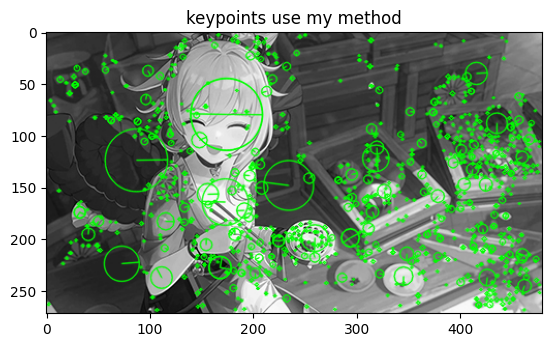

In [299]:
cvkeypoints = convertKeypointsToInputImageSize(cvkeypoints)
img1 = cv.drawKeypoints(raw_image, cvkeypoints, None, color=(0, 255, 0), flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.title("keypoints use my method")
plt.imshow(img1)

特征点个数：992


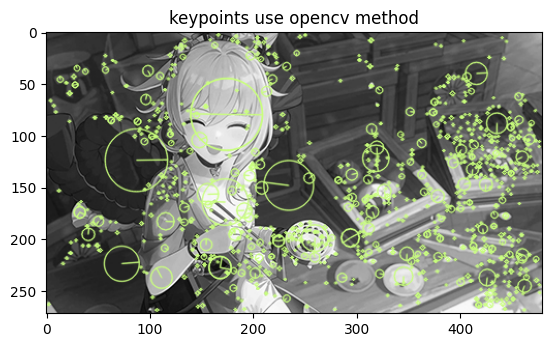

In [300]:
def detect_sift(img):
    sift = cv.SIFT_create() # SIFT特征提取对象
    kp = sift.detect(img, None) # 关键点位置
    kp, des = sift.compute(img, kp) # des为特征向量
    print(f"特征点个数：{len(kp)}")
    return kp, des
kp1, des1 = detect_sift(raw_image)
img1 = cv.drawKeypoints(raw_image, kp1, raw_image, color=(201,255,125), flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.title("keypoints use opencv method")
plt.imshow(img1)

## PS1.2 关键点去重
实际上关键点仍然有部分重复的情况,opencv中的方法有969个关键点，而我们的方法有978个关键点，因此我们需要对关键点进行去重。

In [301]:
def MyCompareKP(kp1, kp2):
    """参考了opencv的代码，对关键点进行排序，然后比较两个关键点是否相同
    """
    if kp1.pt[0] != kp2.pt[0]:
        return kp1.pt[0] - kp2.pt[0]
    if kp1.pt[1] != kp2.pt[1]:
        return kp1.pt[1] - kp2.pt[1]
    if kp1.size != kp2.size:
        return kp2.size - kp1.size
    if kp1.angle != kp2.angle:
        return kp1.angle - kp2.angle
    if kp1.response != kp2.response:
        return kp2.response - kp1.response
    if kp1.octave != kp2.octave:
        return kp2.octave - kp1.octave
    return kp2.class_id - kp1.class_id

def RemoveDuplicateKeypoints(kp):
    """先排序后去重。
    """
    if len(kp) < 2:
        return kp
    kp.sort(key=cmp_to_key(MyCompareKP))
    unique_kp = [kp[0]]
    for temp in kp[1:]:
        last_kp = unique_kp[-1]
        if last_kp.pt[0] != temp.pt[0] or \
           last_kp.pt[1] != temp.pt[1] or \
           last_kp.size != temp.size or \
           last_kp.angle != temp.angle:
            unique_kp.append(temp)
    return unique_kp

In [302]:
removed_cvkeypoints = RemoveDuplicateKeypoints(cvkeypoints)
print(f"removed_cvkeypoints len = {len(removed_cvkeypoints)}")

removed_cvkeypoints len = 992


现在差距只和opencv差了3个关键点，可能是一些计算上的误差了，我觉得基本上接近标准了。

## PS1.3 解析关键点的方向

1. 对octave属性进行移位和按位或运算在OpenCV中，octave属性用于描述图像中的不同特征点，比如角点、边缘等。每个特征点都有一个对应的octave值，表示该特征点属于哪个层级。在这个函数中，我们通过对octave属性进行移位和按位或运算来获取其对应的层数(layer)和尺度(scale)。具体来说，我们首先将octave属性右移8位，然后将其与一个掩码(mask)相与，得到一个二进制数。如果这个二进制数的最高位为1,则表示octave值大于等于128,需要将其转换为负数；否则表示octave值小于等于128,不需要做任何处理。接着，我们将这个二进制数左移8位，得到一个十进制数，表示octave值对应的层数。最后，我们将这个十进制数除以一个缩放因子(scale)，得到一个浮点型数值，表示octave值对应的尺度。
2. 将层数和尺度转换为浮点型数值：在OpenCV中，所有的数值都是用浮点型表示的。因此，我们需要将层数和尺度从整数类型转换为浮点型数值，以便后续的计算和比较。在这个函数中，我们使用了一个简单的转换公式：layer = (octave >> 8) & 255;scale = 1 / np.float32(1 << octave)。这个公式的作用是将octave值转换为一个介于0和255之间的整数，然后将其右移8位，再与一个掩码相与，得到一个二进制数。接着，我们将这个二进制数转换为一个十进制数，并将其除以一个缩放因子，得到一个浮点型数值，表示层数和尺度。

In [303]:
def UnpackOctave(keypoint):
    """解析opencv中的keypoint的octave属性
    """
    octave = keypoint.octave & 255
    layer = (keypoint.octave >> 8) & 255
    if octave >= 128:octave = octave | -128
    scale = 1 / np.float32(1 << octave) if octave >= 0 else np.float32(1 << -octave)
    return octave, layer, scale

# 4 特征点描述子（The local image descriptor）
通过以上步骤，对于每一个关键点，他都拥有了位置pt、方向ori、尺度size。接下来就是为每个关键点建立一个描述符，使其不随各种变化而改变，比如光照变化、视角变化等等。并且描述符应该有较高的独特性，从而提高特征点正确匹配的概率

## 4.1 确定计算描述子所需的区域

1. 将关键点附近的区域划分为d*d(此处论文中d=4)个子区域，每个子区域作为一个种子点，每个种子点有8个方向。考虑到实际计算时，需要采用三线性插值，所需图像窗口边长为$3*3*σ_{oct} *(d+1)$  。并且在考虑到旋转因素的情况下，需要计算的描述子区域为：
$$ r = \frac{3*σ_{oct} *\sqrt{2} (d+1)}{2} $$

2. 为了方便，我们将每个计算区域的坐标轴旋转到与关键点方向一致，然后将关键点的坐标设置为原点，同样因为要保证特征矢量具有旋转不变性，需要以特征点为中心，这样就可以将计算区域旋转一个角度，使得计算区域的坐标轴与关键点方向一致：
$$ {\binom{x^{\prime}}{y^{\prime}}} = \begin{bmatrix} cos(\theta) & -sin(\theta) \\ sin(\theta) & cos(\theta) \end{bmatrix} {\binom{x}{y}} $$
3. 将邻域内的采样点分配到对应的子区域内，将子区域内的梯度值分配到8个方向上，计算其权值。旋转后的采样点 落在子区域的下标为
$$
{\binom{x^{\prime\prime}}{y^{\prime\prime}}}={\frac{1}{3\sigma_{oct}}}{\binom{x^{\prime}}{y^{\prime}}}+{\frac{d}{2}}\ -0.5
$$
原因时因为在坐标归一化之后，此后的特征点局部坐标系将$3\sigma_{orc}$作为了一个单元长度，加上$d/2$是为了把坐标徐由特征点处平移到左上角边界点，再减去0.5将其再移动到中心处

## 4.2 生成特征向量

1. 对于每一个keypoint在确定了区域后，在每子区域内计算8个方向的梯度方向直方图，绘制每个梯度方向的累加值，形成一个种子点。与求特征点主方向时有所不同，此时，每个子区域的梯度方向直方图将0° ~360°划分为8个方向范围，每个范围为45°，这样，每个种子点共有8个方向的梯度强度信息。所以，共有4X4X8=128个数据，最终形成128维的SIFT特征矢量。同样，对于特征矢量需要进行高斯加权处理，其中距离为各点相对于特征点的距离。使用高斯权重的是为了防止位置微小的变化给特征向量带来很大的改变，并且给远离特征点的点赋予较小的权重，以防止错误的匹配。

### 4.2.1 使用三线性插值对梯度幅值进行加权
1. 对于上述4x4的子区域，每个格子内的梯度幅值都需要进行加权，这里使用三线性插值的方法，对于每个格子内的梯度幅值进行加权，具体操作参考文章：[SIFT描述子线性插值](https://www.cnblogs.com/Alliswell-WP/p/SIFT_code4.html)

2. 结果如下所示，可以看到对于每一个区域都被划分为了16个子区域，每个子区域都有8个方向的梯度强度信息，最终形成了128维的特征向量，在这里使用可视化展示其中四张图像的描述子可视化信息
<img src="./img/descript.png">

In [333]:
def CalGradMagOri(half_width, point, img, num_rows, num_cols, hist_width, w, angle, per_degree):
    """计算梯度方向和梯度幅值
    """
    # # 为了保证特征描述子具有旋转不变性，要以特征点为中心，在附近邻域内旋转θ角，即旋转为特征点的方向
    cos_angle = np.cos(np.deg2rad(angle))
    sin_angle = np.sin(np.deg2rad(angle))
    row_list = []
    col_list = []
    mag_list = []
    ori_list = []
    for row in range(-half_width, half_width + 1):
        for col in range(-half_width, half_width + 1):
            row_rot = col * sin_angle + row * cos_angle
            col_rot = col * cos_angle - row * sin_angle
            # x' = x * 1/3sigma_oct + 1/2 * d - 0.5
            row_bin = (row_rot / hist_width) + 0.5 * SIFT_DESCR_WIDTH - 0.5
            # y' = y * 1/3sigma_oct + 1/2 * d - 0.5
            col_bin = (col_rot / hist_width) + 0.5 * SIFT_DESCR_WIDTH - 0.5
            if row_bin > -1 and row_bin < SIFT_DESCR_WIDTH and col_bin > -1 and col_bin < SIFT_DESCR_WIDTH:
                window_row = int(round(point[1] + row))
                window_col = int(round(point[0] + col))
                if window_row > 0 and window_row < num_rows - 1 and window_col > 0 and window_col < num_cols - 1:
                    dx = img[window_row, window_col + 1] - img[window_row, window_col - 1]
                    dy = img[window_row - 1, window_col] - img[window_row + 1, window_col]
                    gradient_magnitude = np.sqrt(dx * dx + dy * dy)
                    gradient_orientation = np.rad2deg(np.arctan2(dy, dx)) % 360
                    weight = np.exp(w * ((row_rot / hist_width) ** 2 + (col_rot / hist_width) ** 2))
                    row_list.append(row_bin)
                    col_list.append(col_bin)
                    mag_list.append(gradient_magnitude * weight)
                    ori_list.append((gradient_orientation - angle) * per_degree)
    return row_list, col_list, mag_list, ori_list

def CalTrilinearFrac(mag, row_frac, col_frac, ori_frac):
    c1 = mag * row_frac
    c0 = mag * (1 - row_frac)
    c11 = c1 * col_frac
    c10 = c1 * (1 - col_frac)
    c01 = c0 * col_frac
    c00 = c0 * (1 - col_frac)
    c111 = c11 * ori_frac
    c110 = c11 * (1 - ori_frac)
    c101 = c10 * ori_frac
    c100 = c10 * (1 - ori_frac)
    c011 = c01 * ori_frac
    c010 = c01 * (1 - ori_frac)
    c001 = c00 * ori_frac
    c000 = c00 * (1 - ori_frac)
    return c000, c001, c010, c011, c100, c101, c110, c111

def CalTrilinearInterpolation(row_list, col_list, mag_list, ori_list, hist_append):
    """三线性插值
    """
    for row_bin, col_bin, mag, ori_bin in zip(row_list, col_list, mag_list, ori_list):
        row_bin_floor, col_bin_floor, ori_bin_floor = np.floor([row_bin, col_bin, ori_bin]).astype(int)
        row_frac, col_frac, ori_frac = row_bin - row_bin_floor, col_bin - col_bin_floor, ori_bin - ori_bin_floor
        if ori_bin_floor < 0:
            ori_bin_floor += SIFT_DESCR_HIST_BINS
        if ori_bin_floor >= SIFT_DESCR_HIST_BINS:
            ori_bin_floor -= SIFT_DESCR_HIST_BINS
        c000, c001, c010, c011, c100, c101, c110, c111 = CalTrilinearFrac(mag, row_frac, col_frac, ori_frac)
        hist_append[row_bin_floor + 1, col_bin_floor + 1, ori_bin_floor] += c000
        hist_append[row_bin_floor + 1, col_bin_floor + 1, (ori_bin_floor + 1) % SIFT_DESCR_HIST_BINS] += c001
        hist_append[row_bin_floor + 1, col_bin_floor + 2, ori_bin_floor] += c010
        hist_append[row_bin_floor + 1, col_bin_floor + 2, (ori_bin_floor + 1) % SIFT_DESCR_HIST_BINS] += c011
        hist_append[row_bin_floor + 2, col_bin_floor + 1, ori_bin_floor] += c100
        hist_append[row_bin_floor + 2, col_bin_floor + 1, (ori_bin_floor + 1) % SIFT_DESCR_HIST_BINS] += c101
        hist_append[row_bin_floor + 2, col_bin_floor + 2, ori_bin_floor] += c110
        hist_append[row_bin_floor + 2, col_bin_floor + 2, (ori_bin_floor + 1) % SIFT_DESCR_HIST_BINS] += c111
    return hist_append

def NormalizeDescriptor(hist_append):
    """归一化直方图
    """
    descript = hist_append[1:-1, 1:-1, :].flatten()
    # 归一化
    threshold = np.linalg.norm(descript) * SIFT_DESCR_MAG_THR
    descript[descript > threshold] = threshold
    descript /= max(np.linalg.norm(descript), 1e-7)
    descript = np.round(512 * descript)
    descript[descript < 0] = 0
    descript[descript > 255] = 255
    return descript

# 如果要可视化，把注释DEBUG处的代码取消注释
def generateDescriptors(keypoints, gaussian_img):
    """生成描述子
    """
    cnt = 0
    descriptors = []
    w_fact = -0.5 / ((0.5 * SIFT_DESCR_WIDTH) ** 2)
    # 乘以8/2Π，8为直方图有8个bin，2Π为角度取值范围的长度，把方向的索引归于0~8
    per_degree = SIFT_DESCR_HIST_BINS / 360.
    for kp in keypoints:
        octave, layer, scale = UnpackOctave(kp)
        pr_img = gaussian_img[octave + 1, layer]
        num_rows, num_cols = pr_img.shape
        point = np.round(scale * np.array(kp.pt)).astype('int')
        # bins_per_degree = SIFT_DESCR_HIST_BINS / 360.
        angle = 360. - kp.angle
        # d*d*n的三维直方图数组,实际上分配的大小是d+2*d+2*n
        hist_append = np.zeros((SIFT_DESCR_WIDTH + 2, SIFT_DESCR_WIDTH + 2, SIFT_DESCR_HIST_BINS))
        # 计算特征描述子过程中，特征点周围的d*d个区域中，每个区域的宽度为m*σ个像素，SIFT_DESCR_SCL_FCTR即m的默认值，σ为特征点的尺度，m=3
        hist_width = SIFT_DESCR_SCL_FCTR * 0.5 * scale * kp.size
        # 所以搜索的半径是：SIFT_DESCR_SCL_FCTR * scale * ( d + 1.0 ) * sqrt(2) / 2
        half_width = int(round(hist_width * np.sqrt(2) * (SIFT_DESCR_WIDTH + 1) * 0.5))
        # 取图像长宽和r之间的最小值作为r的值
        half_width = int(min(half_width, np.sqrt(num_rows ** 2 + num_cols ** 2)))
        # 计算梯度幅值和方向
        row_list, col_list, mag_list, ori_list = CalGradMagOri(half_width, point, pr_img, num_rows, num_cols, hist_width,w_fact, angle, per_degree)
        # 计算三线性插值后的直方图
        hist_append = CalTrilinearInterpolation(row_list, col_list, mag_list, ori_list, hist_append)
        # 归一化描述子
        descriptor = NormalizeDescriptor(hist_append)
        descriptors.append(descriptor)
    ##############################DEBUG##############################################################
    #     x1,x2 = point[1] - half_width,point[1] + half_width + 1
    #     y1,y2 = point[0] - half_width,point[0] + half_width + 1
    #     x1,x2 = max(0,x1),min(num_rows,x2)
    #     y1,y2 = max(0,y1),min(num_cols,y2)
    #     # print(f"{num_rows, num_cols}",end=" ")
    #     new_img = pr_img[x1:x2,y1:y2]
    #     if new_img.shape[0] % 4 == 1 and new_img.shape[1] %4 == 1:
    #         cnt += 1
    #         plt.subplot(2, 2, cnt)
    #         #     plt.arrow(x0, y0, length*0.8 * -np.cos(angle), length * -np.sin(angle),
    #         #       head_width=1, head_length=1, fc='yellow', ec='yellow')
    #         new_des = descriptor.reshape(4,4,8)
    #         print(f"point:{point},x1:{x1},x2:{x2},y1:{y1},y2:{y2},shape:{new_img.shape}")
    #         plt.imshow(new_img)
    #         # 定义正方形图像的边长
    #         image_size = new_img.shape[0]
    #         # 定义图像中每个小方块的边长
    #         block_size = image_size // 4
    #         # 遍历每个小方块，并在其中绘制8个方向
    #         color = "darkslateblue"
    #         for i in range(5):
    #             plt.plot([i * block_size, i * block_size], [0, image_size-1], '-', linewidth=3, color=color)
    #             plt.plot([0, image_size-1], [i * block_size, i * block_size], '-', linewidth=3, color=color)
    #         for i in range(4):
    #             for j in range(4):
    #                 x_start = i * block_size + block_size // 2
    #                 y_start = j * block_size + block_size // 2
    #                 for k in range(8):
    #                     lenth = new_des[i,j,k] / np.max(new_des)
    #                     plt.arrow(x_start, y_start, block_size/2.5 * np.sin(k*np.pi/4) * lenth, block_size/2.5 * np.cos(k*np.pi/4) * lenth,
    #                               head_width=0.5, head_length=0.5, fc='yellow', ec='yellow')
    #         plt.title(f"point:{point},x1:{x1},x2:{x2},y1:{y1},y2:{y2},shape:{new_img.shape}")
    #         if cnt > 3:
    #             break
    # # plt.savefig("./img/descript.png")
    # plt.show()
    ########################DEBUG##############################################################
    return np.array(descriptors, dtype='float32')

point:[321 287],x1:251,x2:324,y1:285,y2:358,shape:(73, 73)
point:[356 369],x1:347,x2:392,y1:334,y2:379,shape:(45, 45)
point:[98 90],x1:68,x2:113,y1:76,y2:121,shape:(45, 45)
point:[395 430],x1:404,x2:457,y1:369,y2:422,shape:(53, 53)


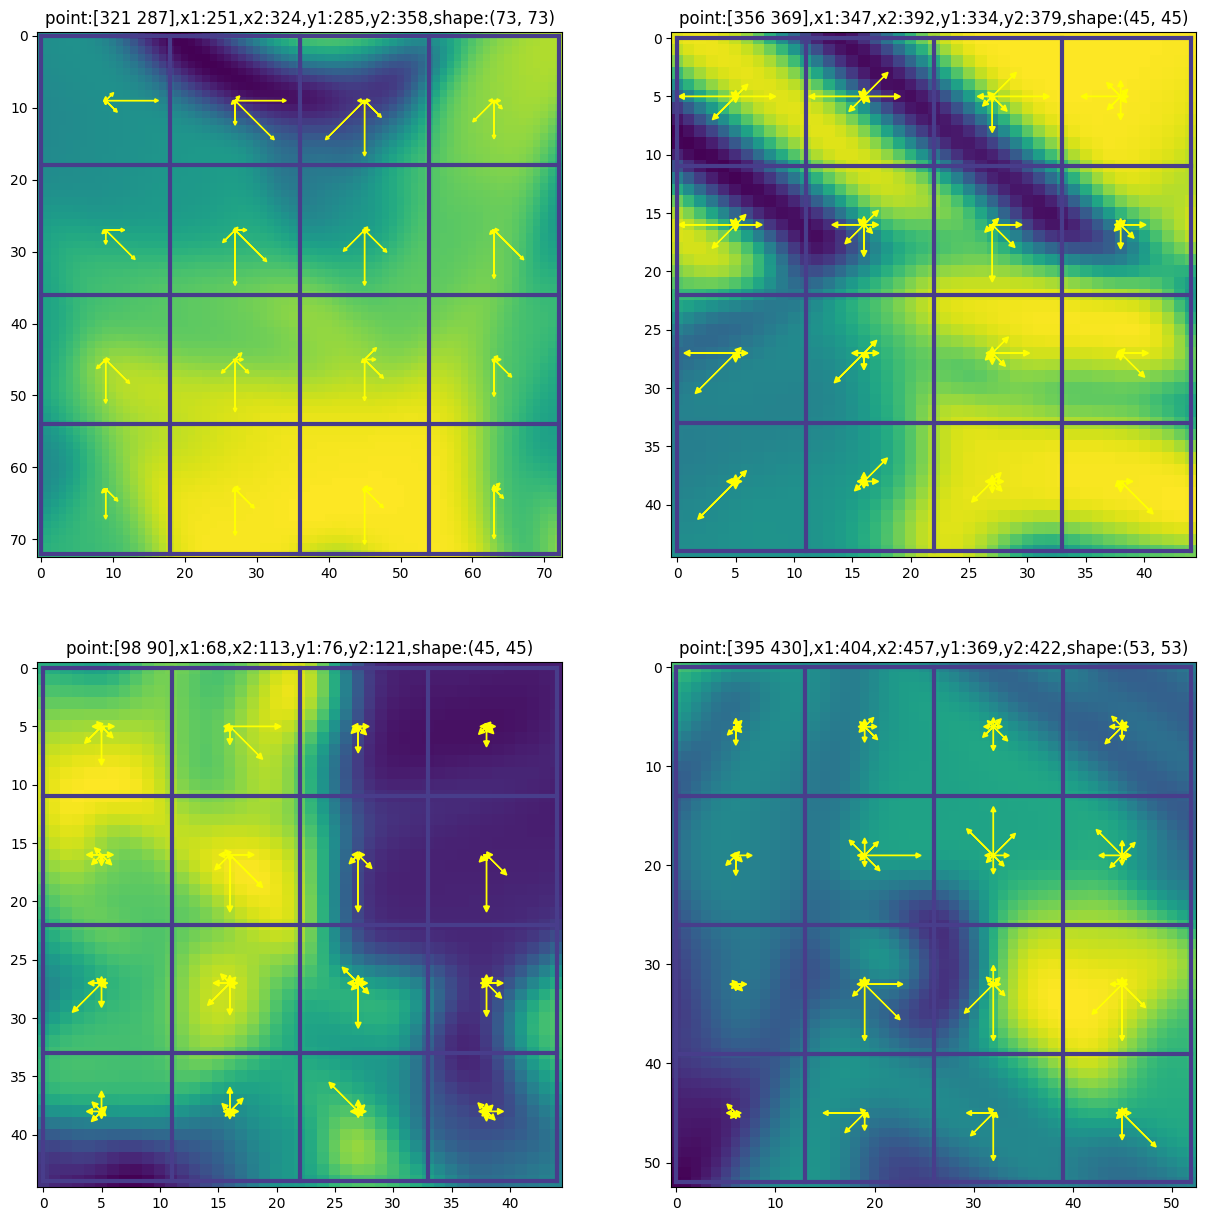

In [323]:
plt.figure(figsize=(15,15))
descriptors = generateDescriptors(removed_cvkeypoints, gaussian_imgs)

# 5 特征点匹配
1. 这一部分参考了互联网上的代码，在寻找特征点匹配时，使用了opencv提供的现成的方法：使用了opencv提供的特征点匹配方法FlannBasedMatcher，得到匹配的特征点。认为小于0.7的距离的特征点是匹配的特征点。使用一个calib3d模块里的函数，cv2.findHomography()，去寻找目标的透视转换，然后我们可以使用cv2.perspectiveTransform()来找目标。

In [334]:
def TempALL(img):
    raw_image = cv.imread(img, 0)
    base_image = Upsampling(raw_image)
    num_octaves = Get_Octaves_Num(base_image)
    guassian_kernels = GenerateGaussianKernels()
    gaussian_imgs = GenerateGaussianImages(base_image, num_octaves, guassian_kernels)
    dog_imgs = GenerateDoGImages(gaussian_imgs)
    keypoints = FindAllKeyPoints(gaussian_imgs, dog_imgs)
    cvkeypoints = MyKeyPoints2CVKeyPoints(keypoints)
    cvkeypoints = convertKeypointsToInputImageSize(cvkeypoints)
    removed_cvkeypoints = RemoveDuplicateKeypoints(cvkeypoints)
    descriptors = generateDescriptors(removed_cvkeypoints, gaussian_imgs)
    return removed_cvkeypoints,descriptors,raw_image

In [373]:
kp1,des1,img1 = TempALL("xiaogonghead.jpg")
kp2,des2,img2 = TempALL("xiaogong.jpg")

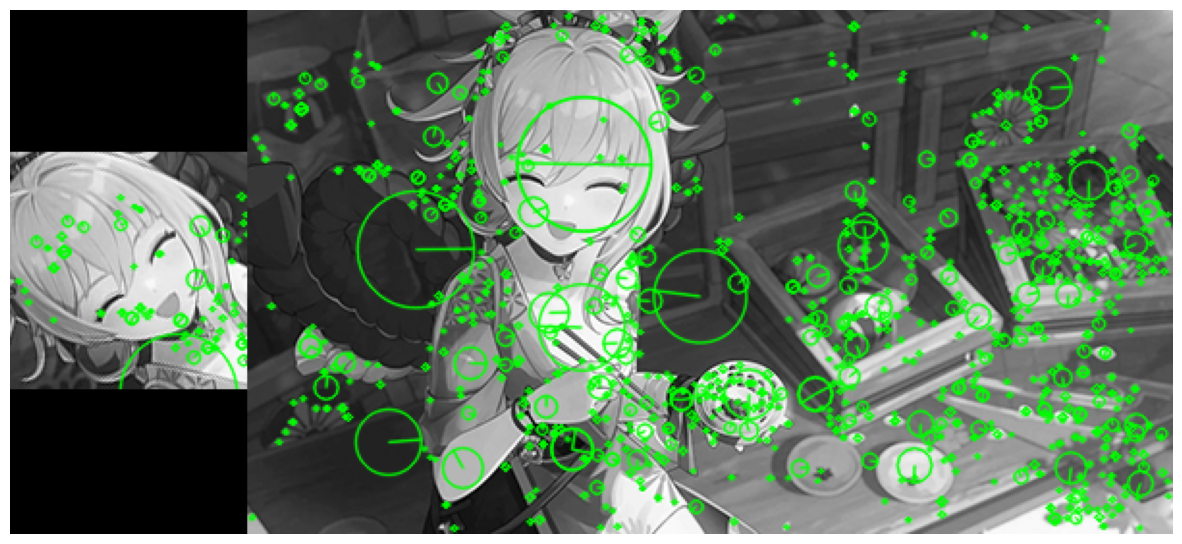

In [374]:
img1_point = cv.drawKeypoints(img1, cvkeypoints, None, color=(0, 255, 0), flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img2_point = cv.drawKeypoints(img2, cvkeypoints, None, color=(0, 255, 0), flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize=(15,15))
h1, w1 = img1.shape
h2, w2 = img2.shape
nWidth = w1 + w2
nHeight = max(h1, h2)
hdif = int((h2 - h1) / 2)
newimg1 = np.zeros((nHeight, nWidth, 3), np.uint8)
for i in range(3):
    newimg1[hdif:hdif + h1, :w1, i] = img1_point[:, :, i]
    newimg1[:h2, w1:w1 + w2, i] = img2_point[:, :, i]
plt.axis('off')
plt.imsave("./img/img1_point.jpg",newimg1)

plt.imshow(newimg1)

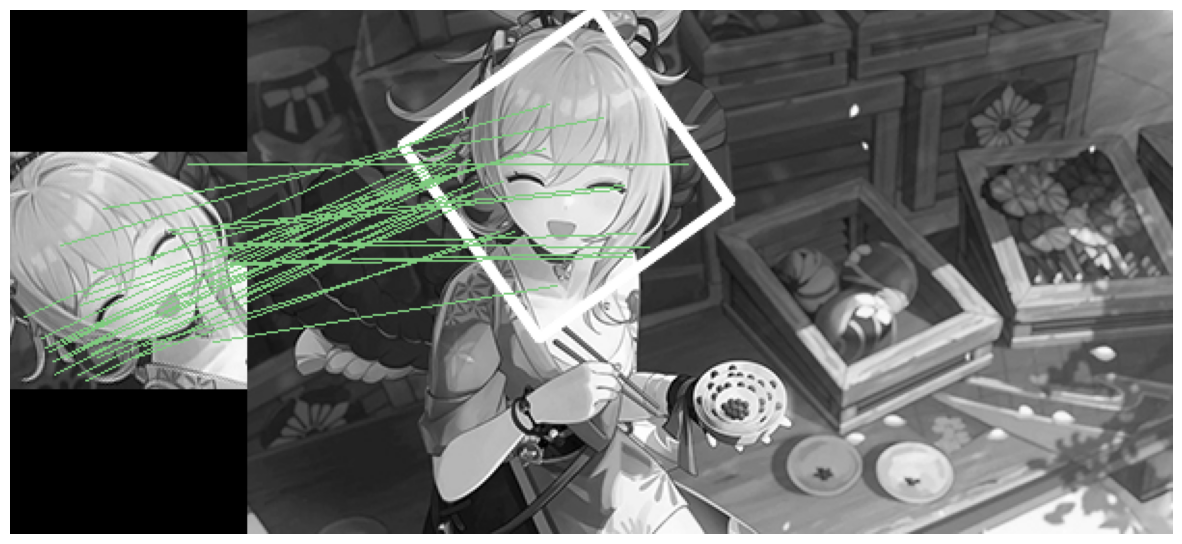

In [371]:
MIN_MATCH = 10
plt.figure(figsize=(15,15))
idx = dict(algorithm = 0, trees = 5)
search = dict(checks = 50)
flann = cv.FlannBasedMatcher(idx, search)
matches = flann.knnMatch(des1, des2, k=2)
good = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good.append(m)
if len(good) > MIN_MATCH:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
    M = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)[0]
    h, w = img1.shape
    pts = np.float32([[0, 0],
                      [0, h - 1],
                      [w - 1, h - 1],
                      [w - 1, 0]]).reshape(-1, 1, 2)
    dst = cv.perspectiveTransform(pts, M)
    img2 = cv.polylines(img2, [np.int32(dst)], True, 255, 3, cv.LINE_AA)
    h1, w1 = img1.shape
    h2, w2 = img2.shape
    nWidth = w1 + w2
    nHeight = max(h1, h2)
    hdif = int((h2 - h1) / 2)
    newimg = np.zeros((nHeight, nWidth, 3), np.uint8)
    for i in range(3):
        newimg[hdif:hdif + h1, :w1, i] = img1
        newimg[:h2, w1:w1 + w2, i] = img2
    # Draw SIFT keypoint matches
    for m in good:
        pt1 = (int(kp1[m.queryIdx].pt[0]), int(kp1[m.queryIdx].pt[1] + hdif))
        pt2 = (int(kp2[m.trainIdx].pt[0] + w1), int(kp2[m.trainIdx].pt[1]))
        cv.line(newimg, pt1, pt2, (127, 203, 127))
    plt.axis("off")
    plt.imsave("./img/img2_point.jpg",newimg)
    plt.imshow(newimg)
    plt.show()
else:
    print(f"图像可能不匹配{len(good)}/{MIN_MATCH}")

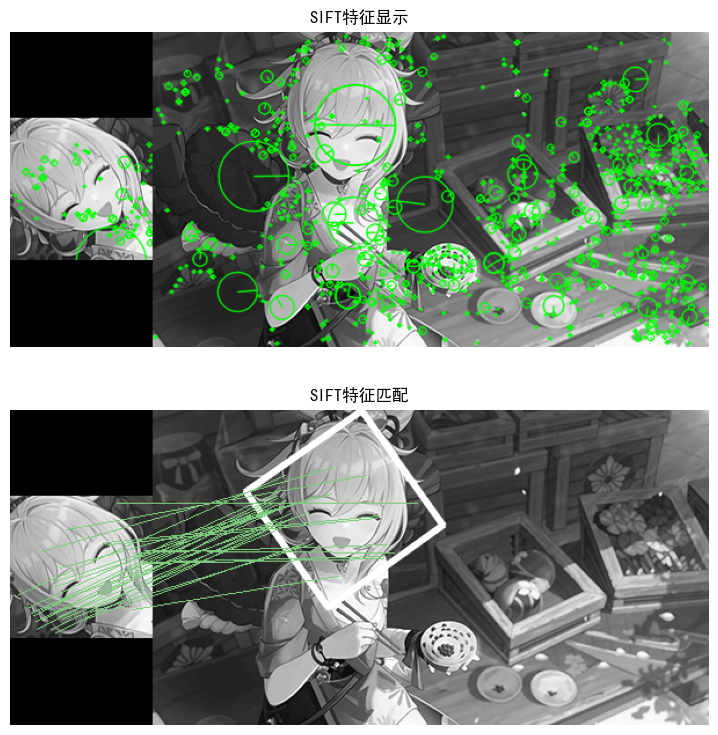

In [363]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.figure(figsize=(10,9))
plt.subplot(2,1,1)
plt.imshow(newimg1)
plt.title("SIFT特征显示")
plt.axis("off")
plt.subplot(2,1,2)
plt.title("SIFT特征匹配")
plt.axis("off")
plt.imshow(newimg)
plt.savefig("./img/SIFT结果.jpg")
plt.show()


# 6 使用多进程加速
1. 在报告中详细说明了使用多进程加速的过程，这里就不再赘述了。基本上在8核cpu上提高了4倍左右的时间